In [19]:
#from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from haversine import haversine
from datetime import datetime
import seaborn as sns
import matplotlib
from matplotlib.pyplot import figure
#import geopandas as gpd
#from geopandas import GeoDataFrame
from matplotlib.dates import DateFormatter

In [20]:
df = pd.read_csv(r'../../data/tidy/large/vehicle-locations-Apr2022.csv', delimiter=',', skiprows=0, low_memory=False)

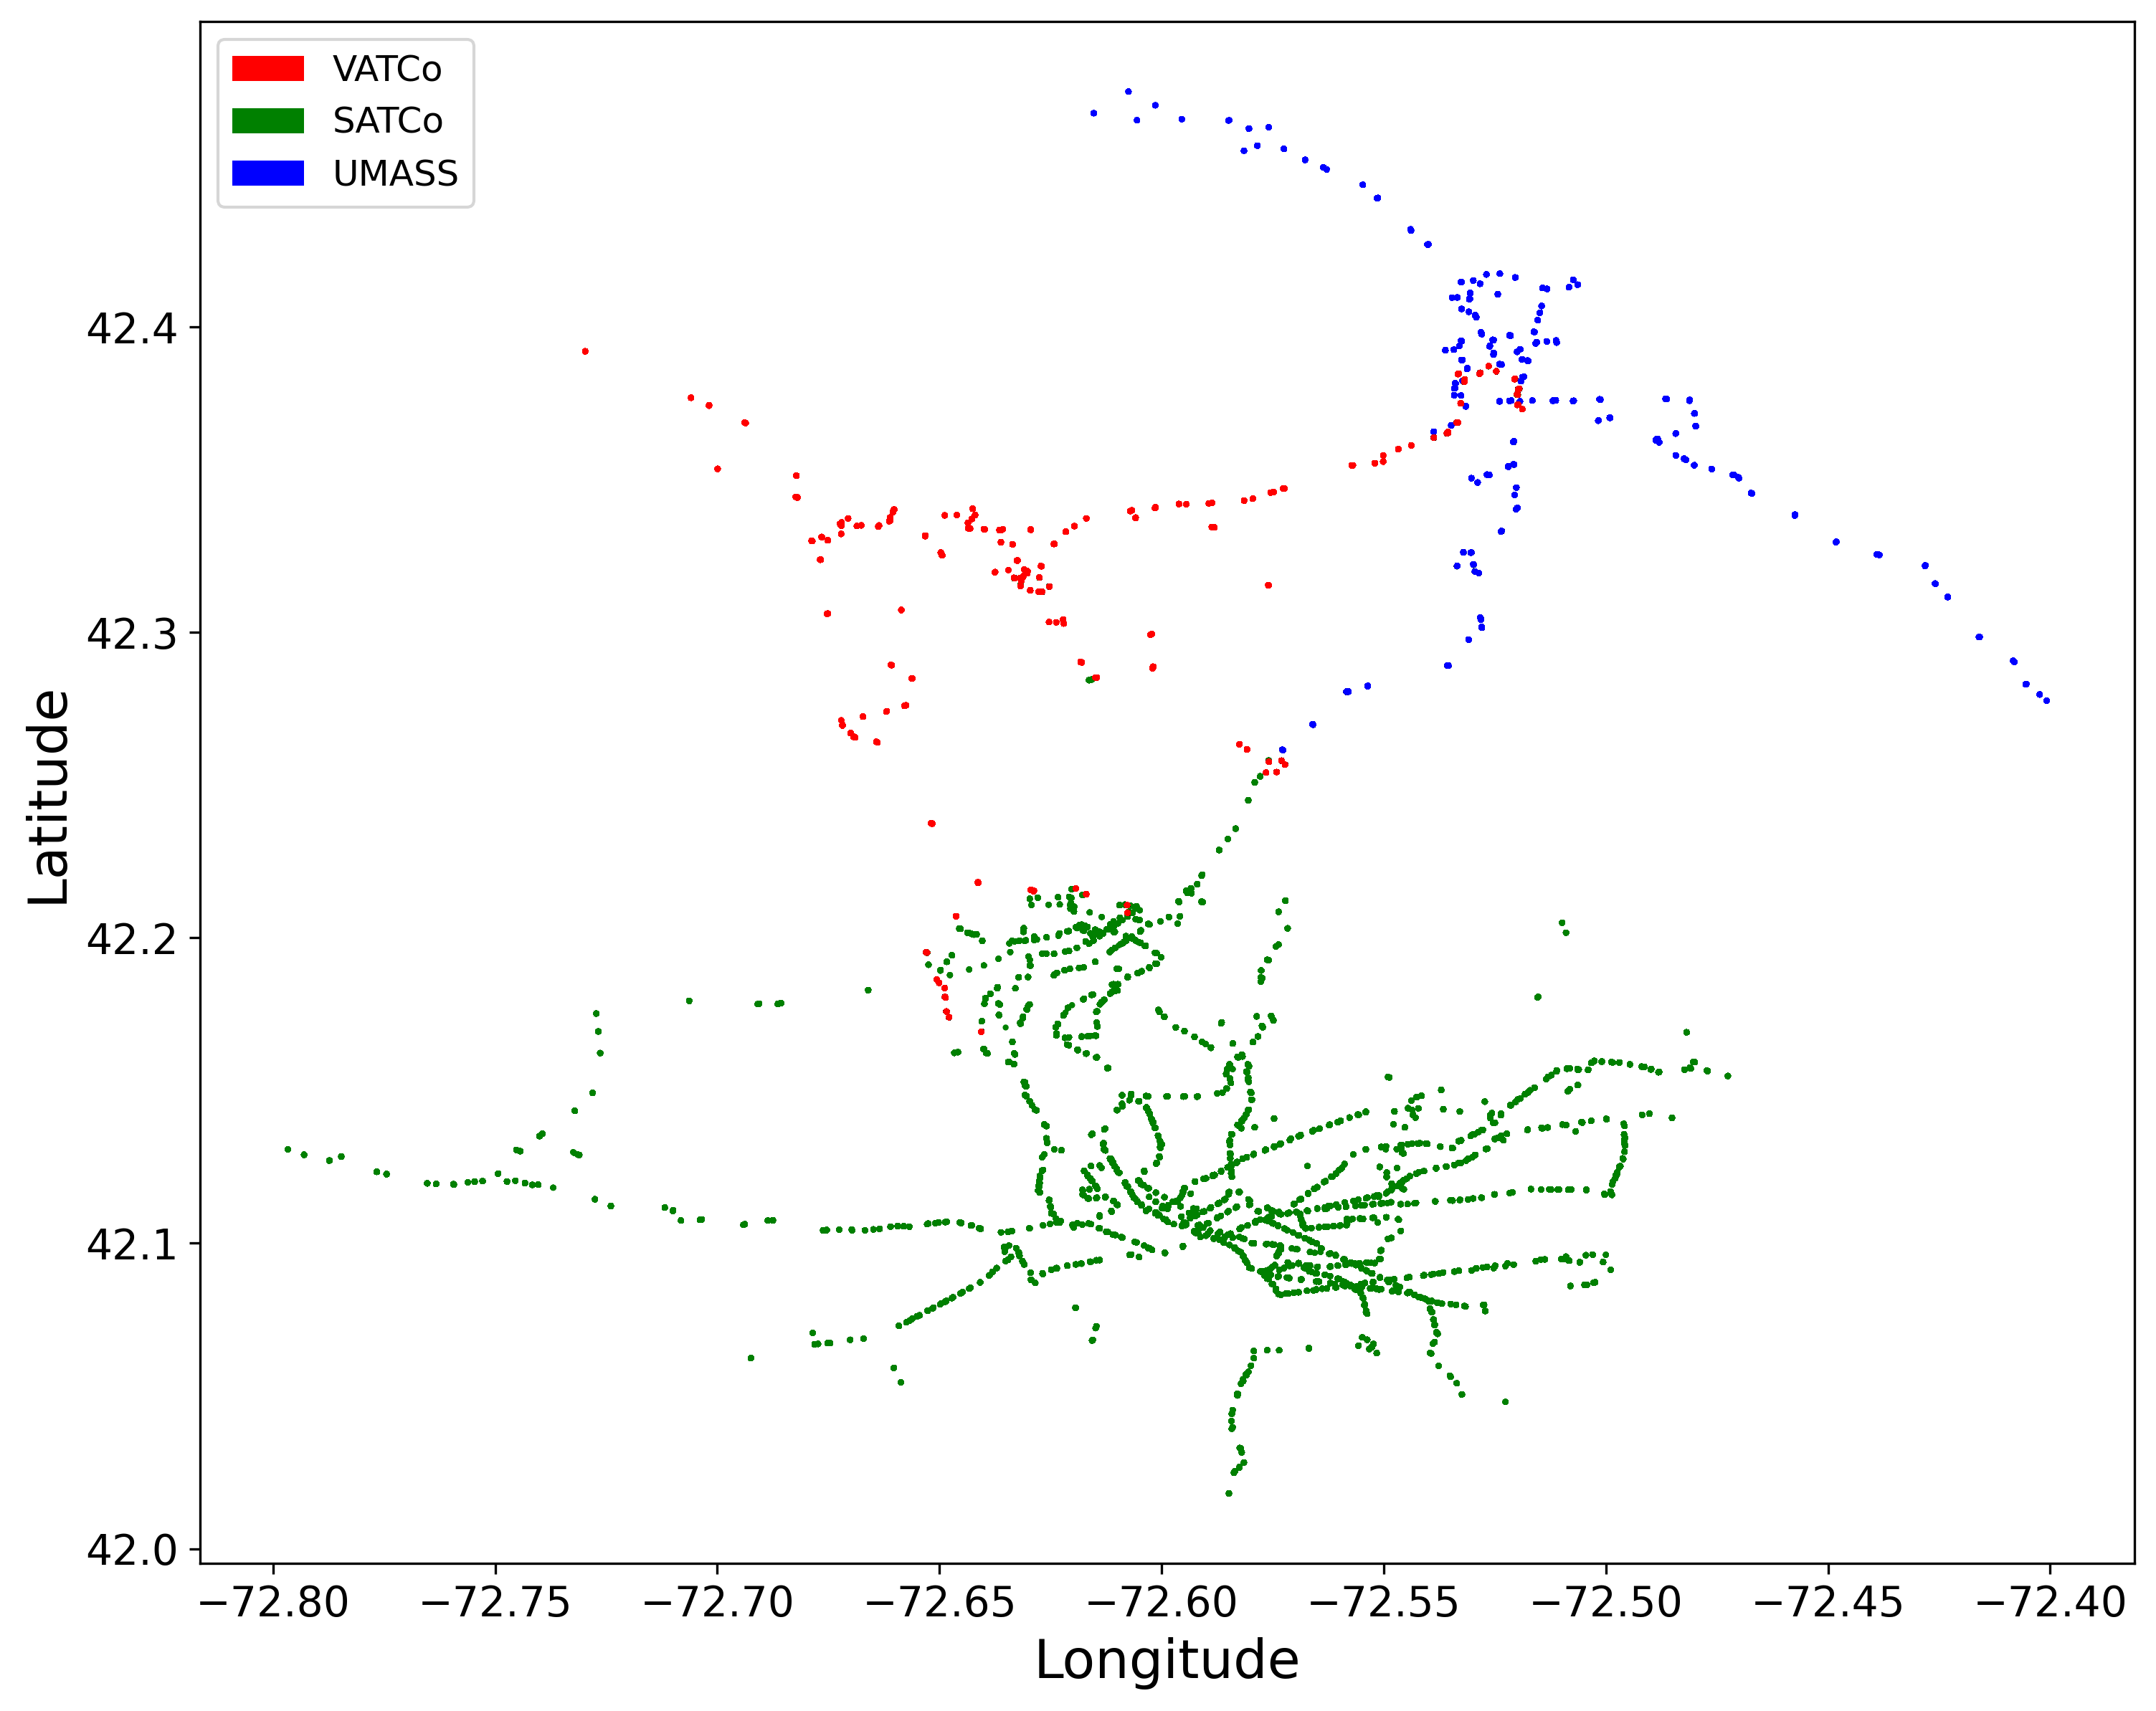

In [261]:
plt.figure(figsize=(10, 8), dpi=300)
colors = {'VATCo':'red', 'SATCo':'green', 'UMASS':'blue'}
plt.scatter(x=df['Lon'], y=df['Lat'], c= df['Operator'].map(colors), s=1)
plt.xlabel("Longitude", fontsize=18)
plt.ylabel("Latitude", fontsize=18)

circ1 = mpatches.Patch(facecolor='red',label='VATCo')
circ2= mpatches.Patch(facecolor='green',label='SATCo')
circ3 = mpatches.Patch(facecolor='blue',label='UMASS')

plt.legend(handles = [circ1,circ2,circ3],loc=2,fontsize=12)
plt.tight_layout()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

plt.savefig(r'../../figures/operators-stops.png', dpi=400, bbox_inches='tight')
plt.show()

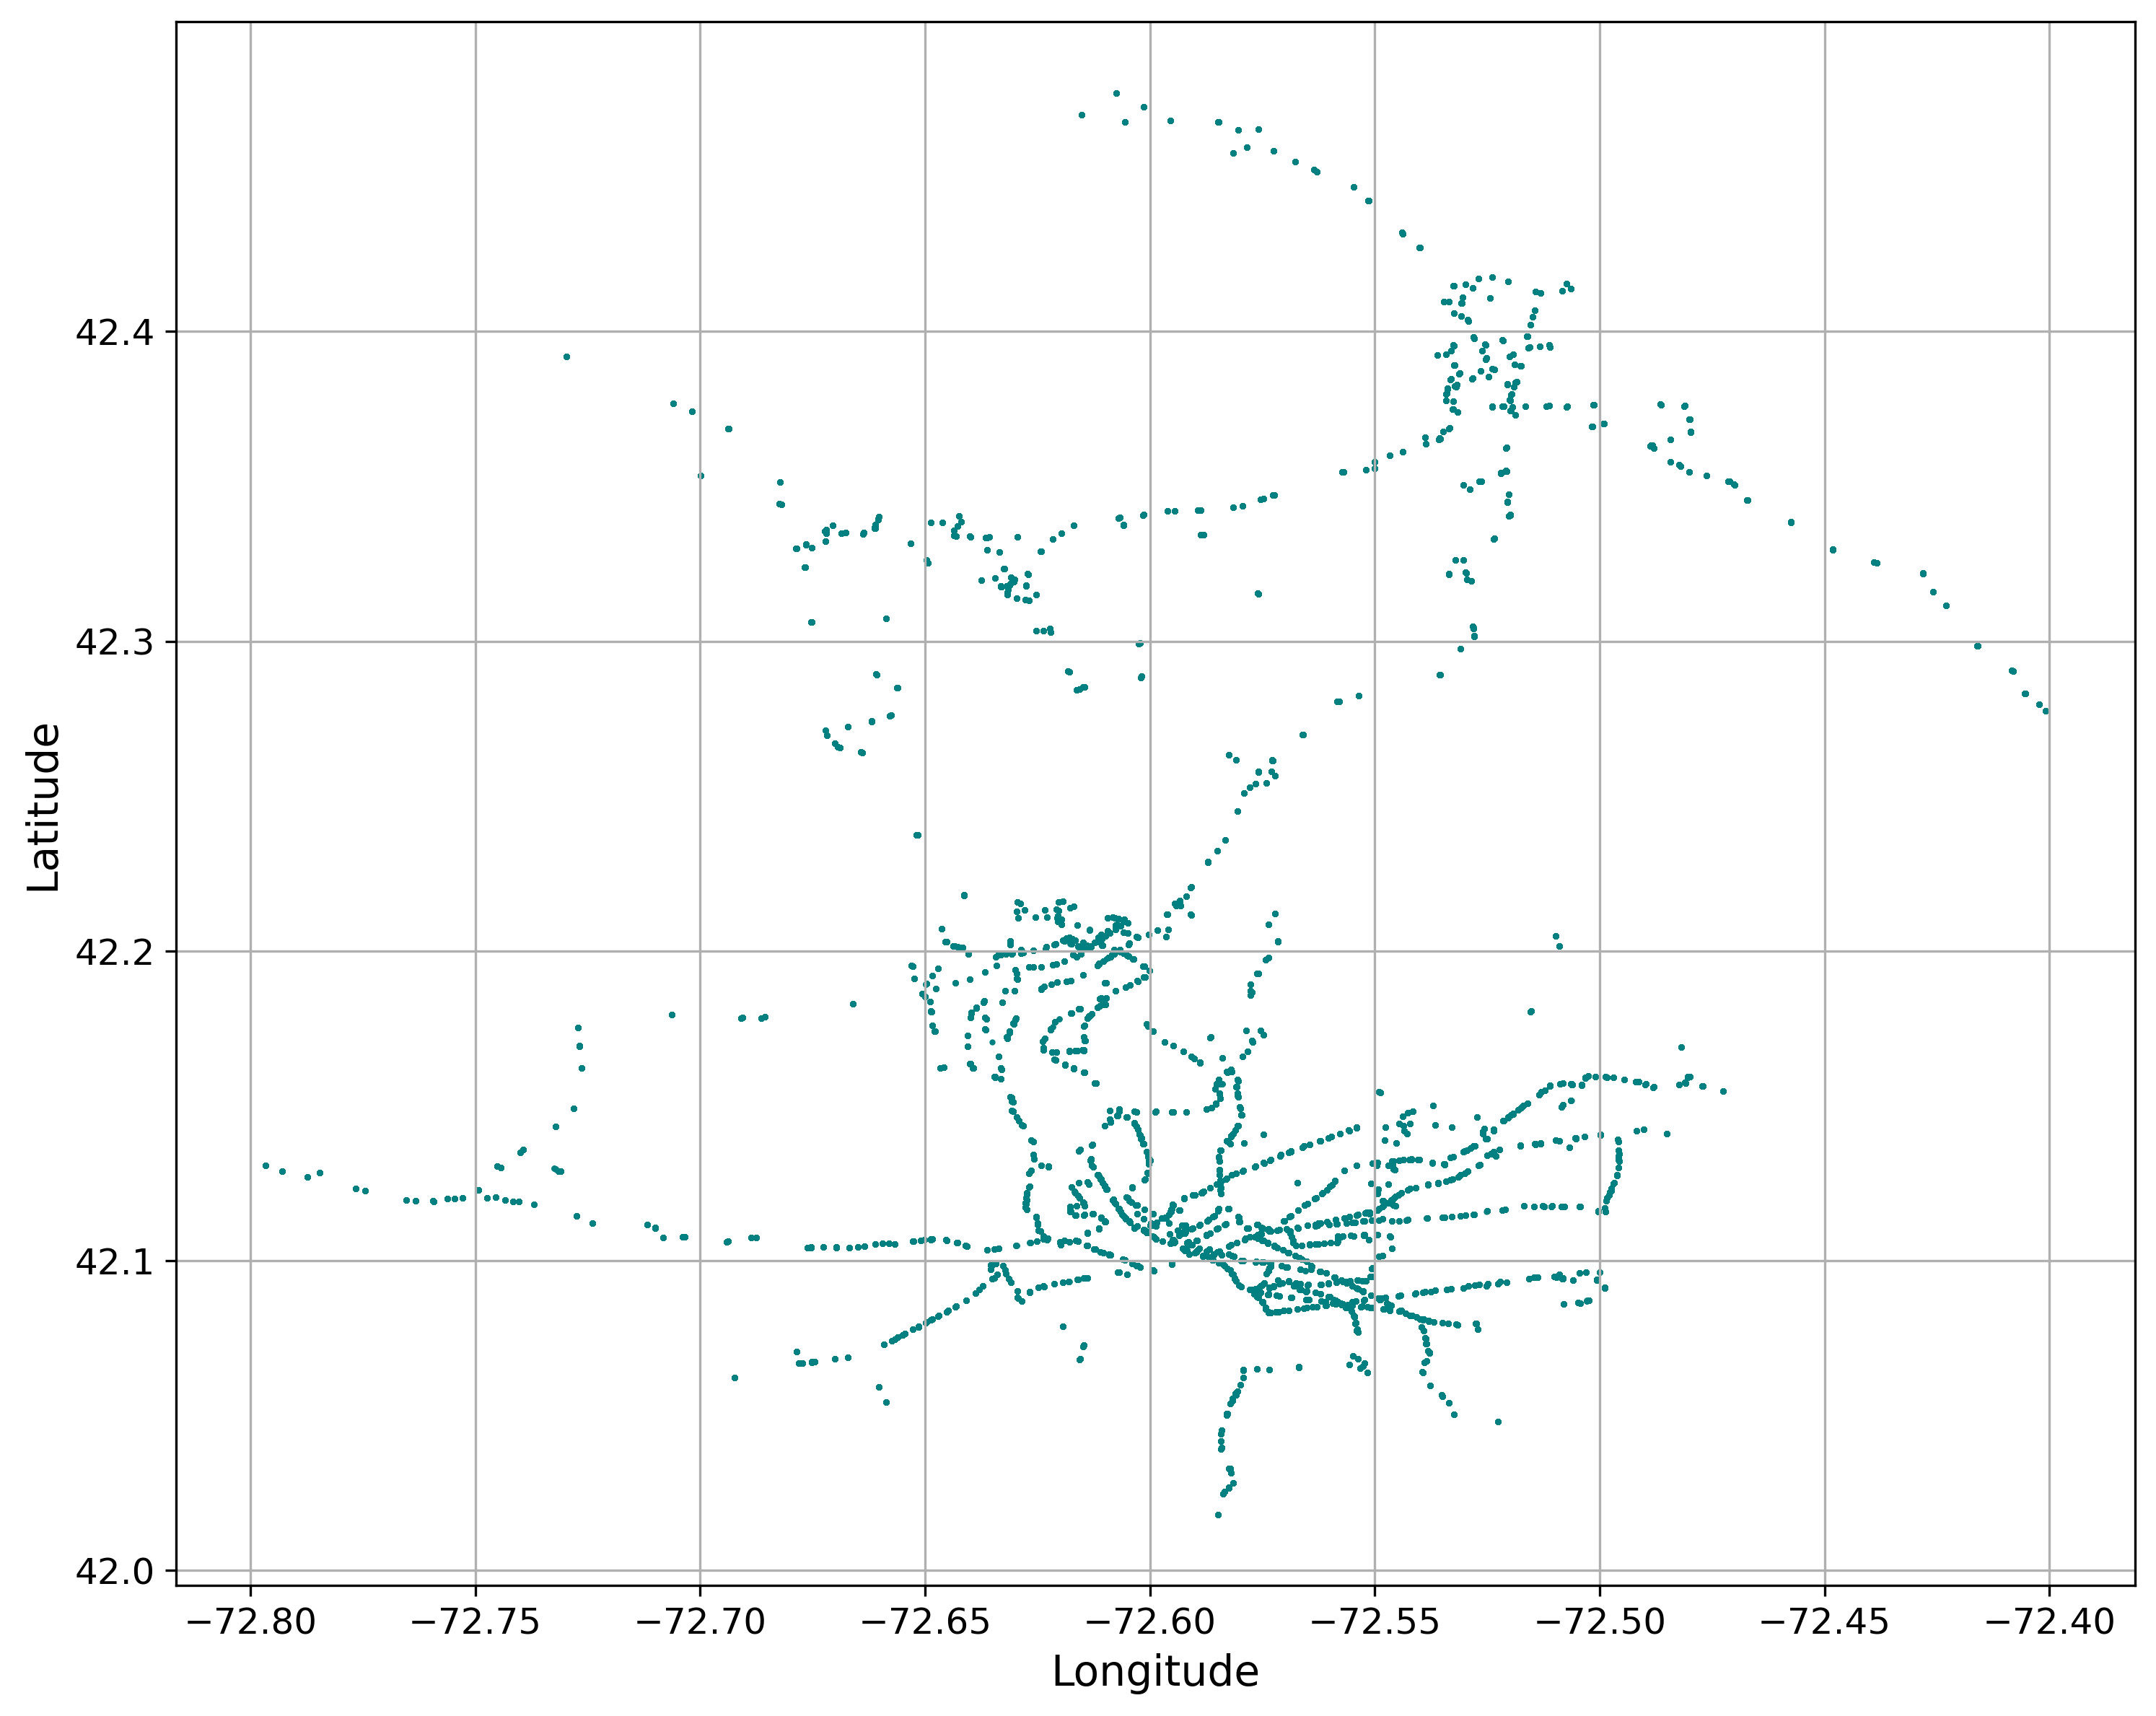

In [262]:
# ver02
plt.figure(figsize=(10, 8), dpi=300)
plt.scatter(x=df['Lon'], y=df['Lat'], s=1, color="teal")
plt.xlabel("Longitude", fontsize=14)
plt.ylabel("Latitude", fontsize=14)

circ1 = mpatches.Patch(facecolor='red',label='VATCo')
circ2= mpatches.Patch(facecolor='green',label='SATCo')
circ3 = mpatches.Patch(facecolor='blue',label='UMASS')

#plt.legend(handles = [circ1,circ2,circ3],loc=2,fontsize=12)
plt.tight_layout()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.grid()

plt.savefig(r'../../figures/operators-stops.png', dpi=400, bbox_inches='tight')
plt.show()

In [21]:
len(df.Vehicle.unique())

178

In [22]:
#vehicles=df.Vehicle.unique()

In [23]:
df.sort_values(by=['Vehicle','ServiceDateTime'], ascending=True, inplace=True)

In [24]:
df[["Vehicle", "ServiceDateTime"]].head(1000)


Vehicle      ServiceDateTime
0       1205  2022-04-04 06:43:24
1       1205  2022-04-04 06:51:27
2       1205  2022-04-04 06:51:27
3       1205  2022-04-04 06:52:52
4       1205  2022-04-04 06:54:33
..       ...                  ...
995     1205  2022-04-13 14:44:34
996     1205  2022-04-13 14:48:53
997     1205  2022-04-13 14:50:19
998     1205  2022-04-13 14:51:45
999     1205  2022-04-13 14:53:20

[1000 rows x 2 columns]

In [25]:
df['ServiceDateTime']= pd.to_datetime(df['ServiceDateTime'])

In [26]:
df[["Vehicle", "ServiceDateTime"]].head(1000)

Vehicle     ServiceDateTime
0       1205 2022-04-04 06:43:24
1       1205 2022-04-04 06:51:27
2       1205 2022-04-04 06:51:27
3       1205 2022-04-04 06:52:52
4       1205 2022-04-04 06:54:33
..       ...                 ...
995     1205 2022-04-13 14:44:34
996     1205 2022-04-13 14:48:53
997     1205 2022-04-13 14:50:19
998     1205 2022-04-13 14:51:45
999     1205 2022-04-13 14:53:20

[1000 rows x 2 columns]

In [27]:
df['time_delta'] = df.groupby(['Vehicle', 'Date'])['ServiceDateTime'].diff()

In [28]:
df.time_delta=df.time_delta.astype(str).str.replace('0 days ', '')

In [29]:
df['time_delta']= pd.to_datetime(df['time_delta'])

In [30]:
df['time_delta_in_seconds'] = df['time_delta'].dt.hour * 3600 + df['time_delta'].dt.minute * 60 + df['time_delta'].dt.second

In [31]:
#46765 data points with time intervals less than 2 sec are filtered 
#df

In [32]:
#calculating distances by unique vehicle Id and unique day
dist=[]
for i in df.index:
    if i==0:
        dist.append(0) 
    else:
        if df['Vehicle'].loc[i]==df['Vehicle'].loc[i-1]:
            if df['Date'].loc[i]==df['Date'].loc[i-1]:           
                coordinate_x = (df['Lon'].loc[i] ,df['Lat'].loc[i]) # (lat, lon) for x
                coordinate_x_minus_1 = (df['Lon'].loc[i-1] ,df['Lat'].loc[i-1]) #(lat, lon) for x-1
                distance=haversine(coordinate_x_minus_1, coordinate_x, unit='mi')
                dist.append(distance) 
            else:
                #dist.append('nan')
                dist.append(0) 
        else:   
            #dist.append('nan')
            dist.append(0) 
df['dist'] = dist
#df.to_csv(r'../../results/computed-distances.csv')

In [33]:
#calculating speed by unique vehicle Id and unique day
speed=[]
for i in df.index:
    if i==0 or i==1:
        speed.append(0) 
    else:
        if df['Vehicle'].loc[i]==df['Vehicle'].loc[i-1]:
            if df['Date'].loc[i]==df['Date'].loc[i-1]:
                FMT = '%H:%M:%S'
                time_diff = abs(datetime.strptime(df['time'].loc[i-1], FMT) - datetime.strptime(df['time'].loc[i], FMT)).total_seconds() / 3600.0
                distance = df['dist'].loc[i]
                if time_diff==0:
                    speed.append(0)
                else:
                    speed_current=distance/time_diff
                    speed.append(speed_current) 
                    #if speed_current>=90:
                        #speed.append(90) 
                    #else:    
                        #speed.append(speed_current)
            else:
                #speed.append('nan')
                speed.append(0) 
        else:   
            #speed.append('nan')
            speed.append(0) 
df['speed'] = speed
#df.to_csv(r'../../results/computed-speeds.csv')

In [34]:
#calculating acceleration by unique vehicle Id and unique day
acc=[]
for i in df.index:
    if i==0 or i==1 or i==2:
        acc.append(0) 
    else:
        if df['Vehicle'].loc[i]==df['Vehicle'].loc[i-1]:
            if df['Date'].loc[i]==df['Date'].loc[i-1]:
                FMT = '%H:%M:%S'
                time_diff = abs(datetime.strptime(df['time'].loc[i-1], FMT) - datetime.strptime(df['time'].loc[i], FMT)).total_seconds() / 3600.0
                #if df['speed'].loc[i-1]=='nan':
                #    df['speed'].loc[i-1]==0
                #else:
                #    pass
                speed_diff = df['speed'].loc[i] - df['speed'].loc[i-1]
                if time_diff==0:
                    acc.append(0) 
                else:
                    acc_current=(speed_diff/time_diff)*0.00012417777777778 # 1 miles/h2 = 0.00012417777777778 m/s2
                    #if -5<acc_current<5:
                    #    acc.append(acc_current)
                    #else:
                    #    acc.append(0)
                    acc.append(acc_current)
            else:
                #acc.append('nan')
                acc.append(0) 
        else:   
            #acc.append('nan')
            acc.append(0) 
df['acc'] = acc
#df.to_csv(r'../../results/computed-trajectories2.csv')

In [74]:
# Make a copy of df with calculated trajectories
df_copy=df.copy()

In [75]:
df_copy

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
0       2022-04-04 06:43:24      112564     8763  2022-04-04 00:00:00.000   
1       2022-04-04 06:51:27      109326     8763  2022-04-04 00:00:00.000   
2       2022-04-04 06:51:27      112565     8763  2022-04-04 00:00:00.000   
3       2022-04-04 06:52:52      109327     8763  2022-04-04 00:00:00.000   
4       2022-04-04 06:54:33      109328     8763  2022-04-04 00:00:00.000   
...                     ...         ...      ...                      ...   
1361544 2022-04-30 23:54:20     1325566     8789  2022-04-30 00:00:00.000   
1361545 2022-04-30 23:55:24     1325567     8789  2022-04-30 00:00:00.000   
1361546 2022-04-30 23:56:47     1325568     8789  2022-04-30 00:00:00.000   
1361547 2022-04-30 23:57:32     1325569     8789  2022-04-30 00:00:00.000   
1361548 2022-04-30 23:59:29     1325570     8789  2022-04-30 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
0        2022      4      1    VATCo   3519    1006  ...     43     24   
1        2022      4      1    VATCo   3513    3380  ...     51     27   
2        2022      4      1    VATCo   3519    1006  ...     51     27   
3        2022      4      1    VATCo   3513    3380  ...     52     52   
4        2022      4      1    VATCo   3513    3380  ...     54     33   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1361544  2022      4      1    VATCo   3515    1001  ...     54     20   
1361545  2022      4      1    VATCo   3515    1001  ...     55     24   
1361546  2022      4      1    VATCo   3515    1001  ...     56     47   
1361547  2022      4      1    VATCo   3515    1001  ...     57     32   
1361548  2022      4      1    VATCo   3515    1001  ...     59     29   

               Date  Daytype      time          time_delta  \
0        2022-04-04  Weekday  06:43:24                 NaT   
1        2022-04-04  Weekday  06:51:27 2022-12-07 00:08:03   
2        2022-04-04  Weekday  06:51:27 2022-12-07 00:00:00   
3        2022-04-04  Weekday  06:52:52 2022-12-07 00:01:25   
4        2022-04-04  Weekday  06:54:33 2022-12-07 00:01:41   
...             ...      ...       ...                 ...   
1361544  2022-04-30  Weekend  23:54:20 2022-12-07 00:02:20   
1361545  2022-04-30  Weekend  23:55:24 2022-12-07 00:01:04   
1361546  2022-04-30  Weekend  23:56:47 2022-12-07 00:01:23   
1361547  2022-04-30  Weekend  23:57:32 2022-12-07 00:00:45   
1361548  2022-04-30  Weekend  23:59:29 2022-12-07 00:01:57   

        time_delta_in_seconds      dist      speed       acc  
0                         NaN  0.000000   0.000000  0.000000  
1                       483.0  0.627342   0.000000  0.000000  
2                         0.0  0.000000   0.000000  0.000000  
3                        85.0  0.313431  13.274729  0.069816  
4                       101.0  0.421734  15.032101  0.007778  
...                       ...       ...        ...       ...  
1361544                 140.0  0.254140   6.535024  0.003673  
1361545                  64.0  0.156799   8.819951  0.015960  
1361546                  83.0  0.144950   6.286980 -0.013643  
1361547                  45.0  0.151259  12.100708  0.057755  
1361548                 117.0  0.780486  24.014951  0.045523  

[1361549 rows x 40 columns]

In [76]:
# Filter data points with time intervals less than 2 seconds and distance greater than 0
df_copy.loc[(df_copy['time_delta_in_seconds'] < 2) & (df_copy['dist'] > 0)]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
24557   2022-04-12 12:34:33      491343     8771  2022-04-12 00:00:00.000   
27075   2022-04-20 12:01:02      877849     8779  2022-04-20 00:00:00.000   
38970   2022-04-01 06:31:46       43700     8760  2022-04-01 00:00:00.000   
61705   2022-04-27 06:30:21     1164619     8786  2022-04-27 00:00:00.000   
61706   2022-04-27 06:30:21     1196708     8786  2022-04-27 00:00:00.000   
...                     ...         ...      ...                      ...   
1313677 2022-04-11 08:23:00      434247     8770  2022-04-11 00:00:00.000   
1329929 2022-04-05 18:00:01      163589     8764  2022-04-05 00:00:00.000   
1335234 2022-04-08 11:12:01      324247     8767  2022-04-08 00:00:00.000   
1358827 2022-04-21 00:06:01      902475     8780  2022-04-21 00:00:00.000   
1359771 2022-04-24 19:43:01     1039311     8783  2022-04-24 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
24557    2022      4      2    SATCo   3631    1104  ...     34     33   
27075    2022      4      2    SATCo   3653    1096  ...      1      2   
38970    2022      4      2    SATCo   3630    1104  ...     31     46   
61705    2022      4      2    SATCo   3631    1104  ...     30     21   
61706    2022      4      2    SATCo   3655    1099  ...     30     21   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1313677  2022      4      1    VATCo   3515    1001  ...     23      0   
1329929  2022      4      1    VATCo   3514    3381  ...      0      1   
1335234  2022      4      1    VATCo   3515    1001  ...     12      1   
1358827  2022      4      1    VATCo   3515    1001  ...      6      1   
1359771  2022      4      1    VATCo   3515    1001  ...     43      1   

               Date  Daytype      time          time_delta  \
24557    2022-04-12  Weekday  12:34:33 2022-12-07 00:00:00   
27075    2022-04-20  Weekday  12:01:02 2022-12-07 00:00:00   
38970    2022-04-01  Weekday  06:31:46 2022-12-07 00:00:00   
61705    2022-04-27  Weekday  06:30:21 2022-12-07 00:00:00   
61706    2022-04-27  Weekday  06:30:21 2022-12-07 00:00:00   
...             ...      ...       ...                 ...   
1313677  2022-04-11  Weekday  08:23:00 2022-12-07 00:00:00   
1329929  2022-04-05  Weekday  18:00:01 2022-12-07 00:00:01   
1335234  2022-04-08  Weekday  11:12:01 2022-12-07 00:00:01   
1358827  2022-04-21  Weekday  00:06:01 2022-12-07 00:00:01   
1359771  2022-04-24  Weekend  19:43:01 2022-12-07 00:00:01   

        time_delta_in_seconds      dist       speed         acc  
24557                     0.0  0.011762    0.000000    0.000000  
27075                     0.0  0.011762    0.000000    0.000000  
38970                     0.0  0.013400    0.000000    0.000000  
61705                     0.0  0.013400    0.000000    0.000000  
61706                     0.0  0.013400    0.000000    0.000000  
...                       ...       ...         ...         ...  
1313677                   0.0  0.295510    0.000000    0.000000  
1329929                   1.0  0.095676  344.434020  153.975784  
1335234                   1.0  0.071477  257.316006  115.030547  
1358827                   1.0  0.071477  257.316006  115.030547  
1359771                   1.0  0.071477  257.316006  115.030547  

[296 rows x 40 columns]

In [77]:
# Filter data points with time intervals less than 2 seconds and abs acc greater than 0
df_copy.loc[(df_copy["time_delta_in_seconds"] <2) & (df_copy["acc"].abs() > 0)]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
565     2022-04-07 10:56:25      269490     8766  2022-04-07 00:00:00.000   
793     2022-04-13 07:20:36      540385     8772  2022-04-13 00:00:00.000   
810     2022-04-13 07:51:11      540402     8772  2022-04-13 00:00:00.000   
5613    2022-04-27 14:43:48     1165602     8786  2022-04-27 00:00:00.000   
5630    2022-04-27 14:51:30     1164543     8786  2022-04-27 00:00:00.000   
...                     ...         ...      ...                      ...   
1358265 2022-04-15 18:46:37      648241     8774  2022-04-15 00:00:00.000   
1358590 2022-04-20 16:00:17      851548     8779  2022-04-20 00:00:00.000   
1358827 2022-04-21 00:06:01      902475     8780  2022-04-21 00:00:00.000   
1359771 2022-04-24 19:43:01     1039311     8783  2022-04-24 00:00:00.000   
1359856 2022-04-25 10:33:19     1057181     8784  2022-04-25 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
565      2022      4      1    VATCo   3513    3380  ...     56     25   
793      2022      4      1    VATCo   3513    3380  ...     20     36   
810      2022      4      1    VATCo   3513    3380  ...     51     11   
5613     2022      4      2    SATCo   3634    3277  ...     43     48   
5630     2022      4      2    SATCo   3631    1104  ...     51     30   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1358265  2022      4      1    VATCo   3515    1001  ...     46     37   
1358590  2022      4      1    VATCo   3515    1001  ...      0     17   
1358827  2022      4      1    VATCo   3515    1001  ...      6      1   
1359771  2022      4      1    VATCo   3515    1001  ...     43      1   
1359856  2022      4      1    VATCo   3515    1001  ...     33     19   

               Date  Daytype      time          time_delta  \
565      2022-04-07  Weekday  10:56:25 2022-12-07 00:00:01   
793      2022-04-13  Weekday  07:20:36 2022-12-07 00:00:01   
810      2022-04-13  Weekday  07:51:11 2022-12-07 00:00:01   
5613     2022-04-27  Weekday  14:43:48 2022-12-07 00:00:01   
5630     2022-04-27  Weekday  14:51:30 2022-12-07 00:00:01   
...             ...      ...       ...                 ...   
1358265  2022-04-15  Weekday  18:46:37 2022-12-07 00:00:01   
1358590  2022-04-20  Weekday  16:00:17 2022-12-07 00:00:01   
1358827  2022-04-21  Weekday  00:06:01 2022-12-07 00:00:01   
1359771  2022-04-24  Weekend  19:43:01 2022-12-07 00:00:01   
1359856  2022-04-25  Weekday  10:33:19 2022-12-07 00:00:01   

        time_delta_in_seconds      dist       speed         acc  
565                       1.0  0.000000    0.000000   -1.460303  
793                       1.0  0.000000    0.000000   -0.563593  
810                       1.0  0.000000    0.000000   -0.016664  
5613                      1.0  0.000000    0.000000   -3.471534  
5630                      1.0  0.000000    0.000000   -2.103976  
...                       ...       ...         ...         ...  
1358265                   1.0  0.000000    0.000000   -0.579386  
1358590                   1.0  0.000000    0.000000   -1.301371  
1358827                   1.0  0.071477  257.316006  115.030547  
1359771                   1.0  0.071477  257.316006  115.030547  
1359856                   1.0  0.000000    0.000000   -1.671663  

[455 rows x 40 columns]

In [78]:
# Drop rows with time intervals less than 2 seconds and distance greater than 0 (296 rows)
df_copy.drop(df_copy.loc[(df_copy["time_delta_in_seconds"] <2) & (df_copy["dist"] > 0)].index, inplace=True)
df_copy.drop(df_copy.loc[(df_copy["time_delta_in_seconds"] <2) & (df_copy["acc"].abs() > 0)].index, inplace=True)

In [79]:
df_copy

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
0       2022-04-04 06:43:24      112564     8763  2022-04-04 00:00:00.000   
1       2022-04-04 06:51:27      109326     8763  2022-04-04 00:00:00.000   
2       2022-04-04 06:51:27      112565     8763  2022-04-04 00:00:00.000   
3       2022-04-04 06:52:52      109327     8763  2022-04-04 00:00:00.000   
4       2022-04-04 06:54:33      109328     8763  2022-04-04 00:00:00.000   
...                     ...         ...      ...                      ...   
1361544 2022-04-30 23:54:20     1325566     8789  2022-04-30 00:00:00.000   
1361545 2022-04-30 23:55:24     1325567     8789  2022-04-30 00:00:00.000   
1361546 2022-04-30 23:56:47     1325568     8789  2022-04-30 00:00:00.000   
1361547 2022-04-30 23:57:32     1325569     8789  2022-04-30 00:00:00.000   
1361548 2022-04-30 23:59:29     1325570     8789  2022-04-30 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
0        2022      4      1    VATCo   3519    1006  ...     43     24   
1        2022      4      1    VATCo   3513    3380  ...     51     27   
2        2022      4      1    VATCo   3519    1006  ...     51     27   
3        2022      4      1    VATCo   3513    3380  ...     52     52   
4        2022      4      1    VATCo   3513    3380  ...     54     33   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1361544  2022      4      1    VATCo   3515    1001  ...     54     20   
1361545  2022      4      1    VATCo   3515    1001  ...     55     24   
1361546  2022      4      1    VATCo   3515    1001  ...     56     47   
1361547  2022      4      1    VATCo   3515    1001  ...     57     32   
1361548  2022      4      1    VATCo   3515    1001  ...     59     29   

               Date  Daytype      time          time_delta  \
0        2022-04-04  Weekday  06:43:24                 NaT   
1        2022-04-04  Weekday  06:51:27 2022-12-07 00:08:03   
2        2022-04-04  Weekday  06:51:27 2022-12-07 00:00:00   
3        2022-04-04  Weekday  06:52:52 2022-12-07 00:01:25   
4        2022-04-04  Weekday  06:54:33 2022-12-07 00:01:41   
...             ...      ...       ...                 ...   
1361544  2022-04-30  Weekend  23:54:20 2022-12-07 00:02:20   
1361545  2022-04-30  Weekend  23:55:24 2022-12-07 00:01:04   
1361546  2022-04-30  Weekend  23:56:47 2022-12-07 00:01:23   
1361547  2022-04-30  Weekend  23:57:32 2022-12-07 00:00:45   
1361548  2022-04-30  Weekend  23:59:29 2022-12-07 00:01:57   

        time_delta_in_seconds      dist      speed       acc  
0                         NaN  0.000000   0.000000  0.000000  
1                       483.0  0.627342   0.000000  0.000000  
2                         0.0  0.000000   0.000000  0.000000  
3                        85.0  0.313431  13.274729  0.069816  
4                       101.0  0.421734  15.032101  0.007778  
...                       ...       ...        ...       ...  
1361544                 140.0  0.254140   6.535024  0.003673  
1361545                  64.0  0.156799   8.819951  0.015960  
1361546                  83.0  0.144950   6.286980 -0.013643  
1361547                  45.0  0.151259  12.100708  0.057755  
1361548                 117.0  0.780486  24.014951  0.045523  

[1360951 rows x 40 columns]

In [80]:
df_copy.loc[df_copy['acc']>5]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
13249   2022-04-12 15:00:05      492916     8771  2022-04-12 00:00:00.000   
14216   2022-04-28 14:58:32     1220646     8787  2022-04-28 00:00:00.000   
27072   2022-04-20 11:27:27      858458     8779  2022-04-20 00:00:00.000   
35590   2022-04-12 14:53:05      491234     8771  2022-04-12 00:00:00.000   
37198   2022-04-21 12:29:02      934677     8780  2022-04-21 00:00:00.000   
...                     ...         ...      ...                      ...   
1336101 2022-04-12 06:00:11      487703     8771  2022-04-12 00:00:00.000   
1342604 2022-04-12 18:09:02      488979     8771  2022-04-12 00:00:00.000   
1344396 2022-04-19 09:26:02      799887     8778  2022-04-19 00:00:00.000   
1346135 2022-04-27 13:00:10     1160508     8786  2022-04-27 00:00:00.000   
1354172 2022-04-23 14:04:02     1002382     8782  2022-04-23 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
13249    2022      4      2    SATCo   3641    3284  ...      0      5   
14216    2022      4      2    SATCo   3641    3284  ...     58     32   
27072    2022      4      2    SATCo   3647    1088  ...     27     27   
35590    2022      4      2    SATCo   3631    1104  ...     53      5   
37198    2022      4      2    SATCo   3655    1099  ...     29      2   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1336101  2022      4      1    VATCo   3515    1001  ...      0     11   
1342604  2022      4      1    VATCo   3515    1001  ...      9      2   
1344396  2022      4      1    VATCo   3515    1001  ...     26      2   
1346135  2022      4      1    VATCo   3410    1007  ...      0     10   
1354172  2022      4      1    VATCo   3515    1001  ...      4      2   

               Date  Daytype      time          time_delta  \
13249    2022-04-12  Weekday  15:00:05 2022-12-07 00:00:02   
14216    2022-04-28  Weekday  14:58:32 2022-12-07 00:00:02   
27072    2022-04-20  Weekday  11:27:27 2022-12-07 00:00:04   
35590    2022-04-12  Weekday  14:53:05 2022-12-07 00:00:04   
37198    2022-04-21  Weekday  12:29:02 2022-12-07 00:00:05   
...             ...      ...       ...                 ...   
1336101  2022-04-12  Weekday  06:00:11 2022-12-07 00:00:11   
1342604  2022-04-12  Weekday  18:09:02 2022-12-07 00:00:02   
1344396  2022-04-19  Weekday  09:26:02 2022-12-07 00:00:02   
1346135  2022-04-27  Weekday  13:00:10 2022-12-07 00:00:10   
1354172  2022-04-23  Weekend  14:04:02 2022-12-07 00:00:02   

        time_delta_in_seconds      dist       speed         acc  
13249                     2.0  0.075489  135.880974   26.716234  
14216                     2.0  0.075489  135.880974   27.025182  
27072                     4.0  0.058001   52.200869    5.180541  
35590                     4.0  0.101070   90.962783    9.794526  
37198                     5.0  0.095352   68.653784    5.413311  
...                       ...       ...         ...         ...  
1336101                  11.0  0.631544  206.687013    8.399760  
1342604                   2.0  0.071477  128.658003   28.757637  
1344396                   2.0  0.295510  531.918132  118.894341  
1346135                  10.0  0.631544  227.355715   10.163710  
1354172                   2.0  0.295510  531.918132  118.894341  

[128 rows x 40 columns]

In [81]:
df_copy.loc[df_copy['acc']<-5]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
262723  2022-04-18 21:51:48      773572     8777  2022-04-18 00:00:00.000   
264845  2022-04-24 17:19:35     1044569     8783  2022-04-24 00:00:00.000   
388112  2022-04-09 12:19:30      386673     8768  2022-04-09 00:00:00.000   
395479  2022-04-25 17:14:24     1095629     8784  2022-04-25 00:00:00.000   
640286  2022-04-26 12:15:38     1131489     8785  2022-04-26 00:00:00.000   
640287  2022-04-26 12:15:54     1131490     8785  2022-04-26 00:00:00.000   
1310835 2022-04-21 23:00:35      902419     8780  2022-04-21 00:00:00.000   
1318238 2022-04-30 14:00:23     1324620     8789  2022-04-30 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
262723   2022      4      2    SATCo   3649    1090  ...     51     48   
264845   2022      4      2    SATCo   3649    1090  ...     19     35   
388112   2022      4      2    SATCo   3604    1089  ...     19     30   
395479   2022      4      2    SATCo   3659    1109  ...     14     24   
640286   2022      4      2    SATCo   3650    1092  ...     15     38   
640287   2022      4      2    SATCo   3650    1092  ...     15     54   
1310835  2022      4      1    VATCo   3515    1001  ...      0     35   
1318238  2022      4      1    VATCo   3515    1001  ...      0     23   

               Date  Daytype      time          time_delta  \
262723   2022-04-18  Weekday  21:51:48 2022-12-07 00:00:03   
264845   2022-04-24  Weekend  17:19:35 2022-12-07 00:00:03   
388112   2022-04-09  Weekend  12:19:30 2022-12-07 00:00:13   
395479   2022-04-25  Weekday  17:14:24 2022-12-07 00:00:20   
640286   2022-04-26  Weekday  12:15:38 2022-12-07 00:00:14   
640287   2022-04-26  Weekday  12:15:54 2022-12-07 00:00:16   
1310835  2022-04-21  Weekday  23:00:35 2022-12-07 00:00:29   
1318238  2022-04-30  Weekend  14:00:23 2022-12-07 00:00:19   

        time_delta_in_seconds      dist       speed        acc  
262723                    3.0  0.014083   16.899752  -6.199198  
264845                    3.0  0.009549   11.459260  -7.042165  
388112                   13.0  0.083751   23.192691 -27.811244  
395479                   20.0  0.116380   20.948482  -8.772657  
640286                   14.0  0.864142  222.207890 -34.497416  
640287                   16.0  0.139823   31.460274  -5.329488  
1310835                  29.0  0.383335   47.586354  -7.360217  
1318238                  19.0  0.205287   38.896498  -6.571564  

[8 rows x 40 columns]

In [82]:
df_copy.drop((df_copy.loc[df_copy['acc']>5]).index, inplace=True)

In [92]:
df_copy.drop((df_copy.loc[df_copy['acc']<-5]).index, inplace=True)

In [94]:
# Filter speed greater than 100 mile
df_copy.loc[df_copy['speed']>100]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
1029334 2022-04-27 08:46:09     1213919     8786  2022-04-27 00:00:00.000   
1188511 2022-04-18 11:02:55      797011     8777  2022-04-18 00:00:00.000   
1218924 2022-04-14 09:22:37      640736     8773  2022-04-14 00:00:00.000   
1245333 2022-04-30 00:40:10     1359890     8789  2022-04-30 00:00:00.000   
1290725 2022-04-09 14:36:04      379674     8768  2022-04-09 00:00:00.000   
1292950 2022-04-27 14:00:28     1163637     8786  2022-04-27 00:00:00.000   
1293856 2022-04-01 13:28:01        3332     8760  2022-04-01 00:00:00.000   
1297706 2022-04-29 13:00:17     1268766     8788  2022-04-29 00:00:00.000   
1301663 2022-04-30 08:00:12     1325764     8789  2022-04-30 00:00:00.000   
1306678 2022-04-30 18:00:32     1325060     8789  2022-04-30 00:00:00.000   
1308313 2022-04-07 10:00:10      270151     8766  2022-04-07 00:00:00.000   
1308831 2022-04-08 17:00:15      325901     8767  2022-04-08 00:00:00.000   
1308879 2022-04-11 08:00:15      433675     8770  2022-04-11 00:00:00.000   
1312348 2022-04-03 10:00:15       92005     8762  2022-04-03 00:00:00.000   
1312406 2022-04-03 13:00:13       92065     8762  2022-04-03 00:00:00.000   
1315564 2022-04-17 16:00:12      737106     8776  2022-04-17 00:00:00.000   
1315584 2022-04-17 17:00:12      737125     8776  2022-04-17 00:00:00.000   
1316694 2022-04-23 18:00:18     1002896     8782  2022-04-23 00:00:00.000   
1316928 2022-04-25 07:00:14     1056900     8784  2022-04-25 00:00:00.000   
1318101 2022-04-30 10:00:16     1324194     8789  2022-04-30 00:00:00.000   
1318269 2022-04-30 15:00:14     1324712     8789  2022-04-30 00:00:00.000   
1319583 2022-04-05 07:00:17      163130     8764  2022-04-05 00:00:00.000   
1320260 2022-04-09 16:00:12      379406     8768  2022-04-09 00:00:00.000   
1325861 2022-04-07 19:17:00      271285     8766  2022-04-07 00:00:00.000   
1326845 2022-04-15 14:06:15      648821     8774  2022-04-15 00:00:00.000   
1326953 2022-04-18 13:00:21      755234     8777  2022-04-18 00:00:00.000   
1332327 2022-04-22 13:00:17      950790     8781  2022-04-22 00:00:00.000   
1343877 2022-04-18 06:32:17      754667     8777  2022-04-18 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
1029334  2022      4      3    UMASS   3629    1745  ...     46      9   
1188511  2022      4      3    UMASS   3626    1734  ...      2     55   
1218924  2022      4      3    UMASS   3625    1733  ...     22     37   
1245333  2022      4      3    UMASS   3626    1734  ...     40     10   
1290725  2022      4      1    VATCo   3517    1004  ...     36      4   
1292950  2022      4      1    VATCo   3518    1005  ...      0     28   
1293856  2022      4      1    VATCo   3518    1005  ...     28      1   
1297706  2022      4      1    VATCo   3410    1007  ...      0     17   
1301663  2022      4      1    VATCo   3517    1004  ...      0     12   
1306678  2022      4      1    VATCo   3515    1001  ...      0     32   
1308313  2022      4      1    VATCo   3515    1001  ...      0     10   
1308831  2022      4      1    VATCo   3516    1002  ...      0     15   
1308879  2022      4      1    VATCo   3410    1007  ...      0     15   
1312348  2022      4      1    VATCo   3516    1002  ...      0     15   
1312406  2022      4      1    VATCo   3516    1002  ...      0     13   
1315564  2022      4      1    VATCo   3516    1002  ...      0     12   
1315584  2022      4      1    VATCo   3516    1002  ...      0     12   
1316694  2022      4      1    VATCo   3515    1001  ...      0     18   
1316928  2022      4      1    VATCo   3515    1001  ...      0     14   
1318101  2022      4      1    VATCo   3515    1001  ...      0     16   
1318269  2022      4      1    VATCo   3515    1001  ...      0     14   
1319583  2022      4      1    VATCo   3410    1007  ...      0     17   
1320260  2022      4      1    VATCo   3516    1002  ...      0     12   
13

In [95]:
df_copy.drop((df_copy.loc[df_copy['speed']>100]).index, inplace=True)

In [96]:
df_copy

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
0       2022-04-04 06:43:24      112564     8763  2022-04-04 00:00:00.000   
1       2022-04-04 06:51:27      109326     8763  2022-04-04 00:00:00.000   
2       2022-04-04 06:51:27      112565     8763  2022-04-04 00:00:00.000   
3       2022-04-04 06:52:52      109327     8763  2022-04-04 00:00:00.000   
4       2022-04-04 06:54:33      109328     8763  2022-04-04 00:00:00.000   
...                     ...         ...      ...                      ...   
1361544 2022-04-30 23:54:20     1325566     8789  2022-04-30 00:00:00.000   
1361545 2022-04-30 23:55:24     1325567     8789  2022-04-30 00:00:00.000   
1361546 2022-04-30 23:56:47     1325568     8789  2022-04-30 00:00:00.000   
1361547 2022-04-30 23:57:32     1325569     8789  2022-04-30 00:00:00.000   
1361548 2022-04-30 23:59:29     1325570     8789  2022-04-30 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
0        2022      4      1    VATCo   3519    1006  ...     43     24   
1        2022      4      1    VATCo   3513    3380  ...     51     27   
2        2022      4      1    VATCo   3519    1006  ...     51     27   
3        2022      4      1    VATCo   3513    3380  ...     52     52   
4        2022      4      1    VATCo   3513    3380  ...     54     33   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1361544  2022      4      1    VATCo   3515    1001  ...     54     20   
1361545  2022      4      1    VATCo   3515    1001  ...     55     24   
1361546  2022      4      1    VATCo   3515    1001  ...     56     47   
1361547  2022      4      1    VATCo   3515    1001  ...     57     32   
1361548  2022      4      1    VATCo   3515    1001  ...     59     29   

               Date  Daytype      time          time_delta  \
0        2022-04-04  Weekday  06:43:24                 NaT   
1        2022-04-04  Weekday  06:51:27 2022-12-07 00:08:03   
2        2022-04-04  Weekday  06:51:27 2022-12-07 00:00:00   
3        2022-04-04  Weekday  06:52:52 2022-12-07 00:01:25   
4        2022-04-04  Weekday  06:54:33 2022-12-07 00:01:41   
...             ...      ...       ...                 ...   
1361544  2022-04-30  Weekend  23:54:20 2022-12-07 00:02:20   
1361545  2022-04-30  Weekend  23:55:24 2022-12-07 00:01:04   
1361546  2022-04-30  Weekend  23:56:47 2022-12-07 00:01:23   
1361547  2022-04-30  Weekend  23:57:32 2022-12-07 00:00:45   
1361548  2022-04-30  Weekend  23:59:29 2022-12-07 00:01:57   

        time_delta_in_seconds      dist      speed       acc  
0                         NaN  0.000000   0.000000  0.000000  
1                       483.0  0.627342   0.000000  0.000000  
2                         0.0  0.000000   0.000000  0.000000  
3                        85.0  0.313431  13.274729  0.069816  
4                       101.0  0.421734  15.032101  0.007778  
...                       ...       ...        ...       ...  
1361544                 140.0  0.254140   6.535024  0.003673  
1361545                  64.0  0.156799   8.819951  0.015960  
1361546                  83.0  0.144950   6.286980 -0.013643  
1361547                  45.0  0.151259  12.100708  0.057755  
1361548                 117.0  0.780486  24.014951  0.045523  

[1360787 rows x 40 columns]

In [97]:
df_copy.to_csv(r'../../results/computed-trajectories2.csv')

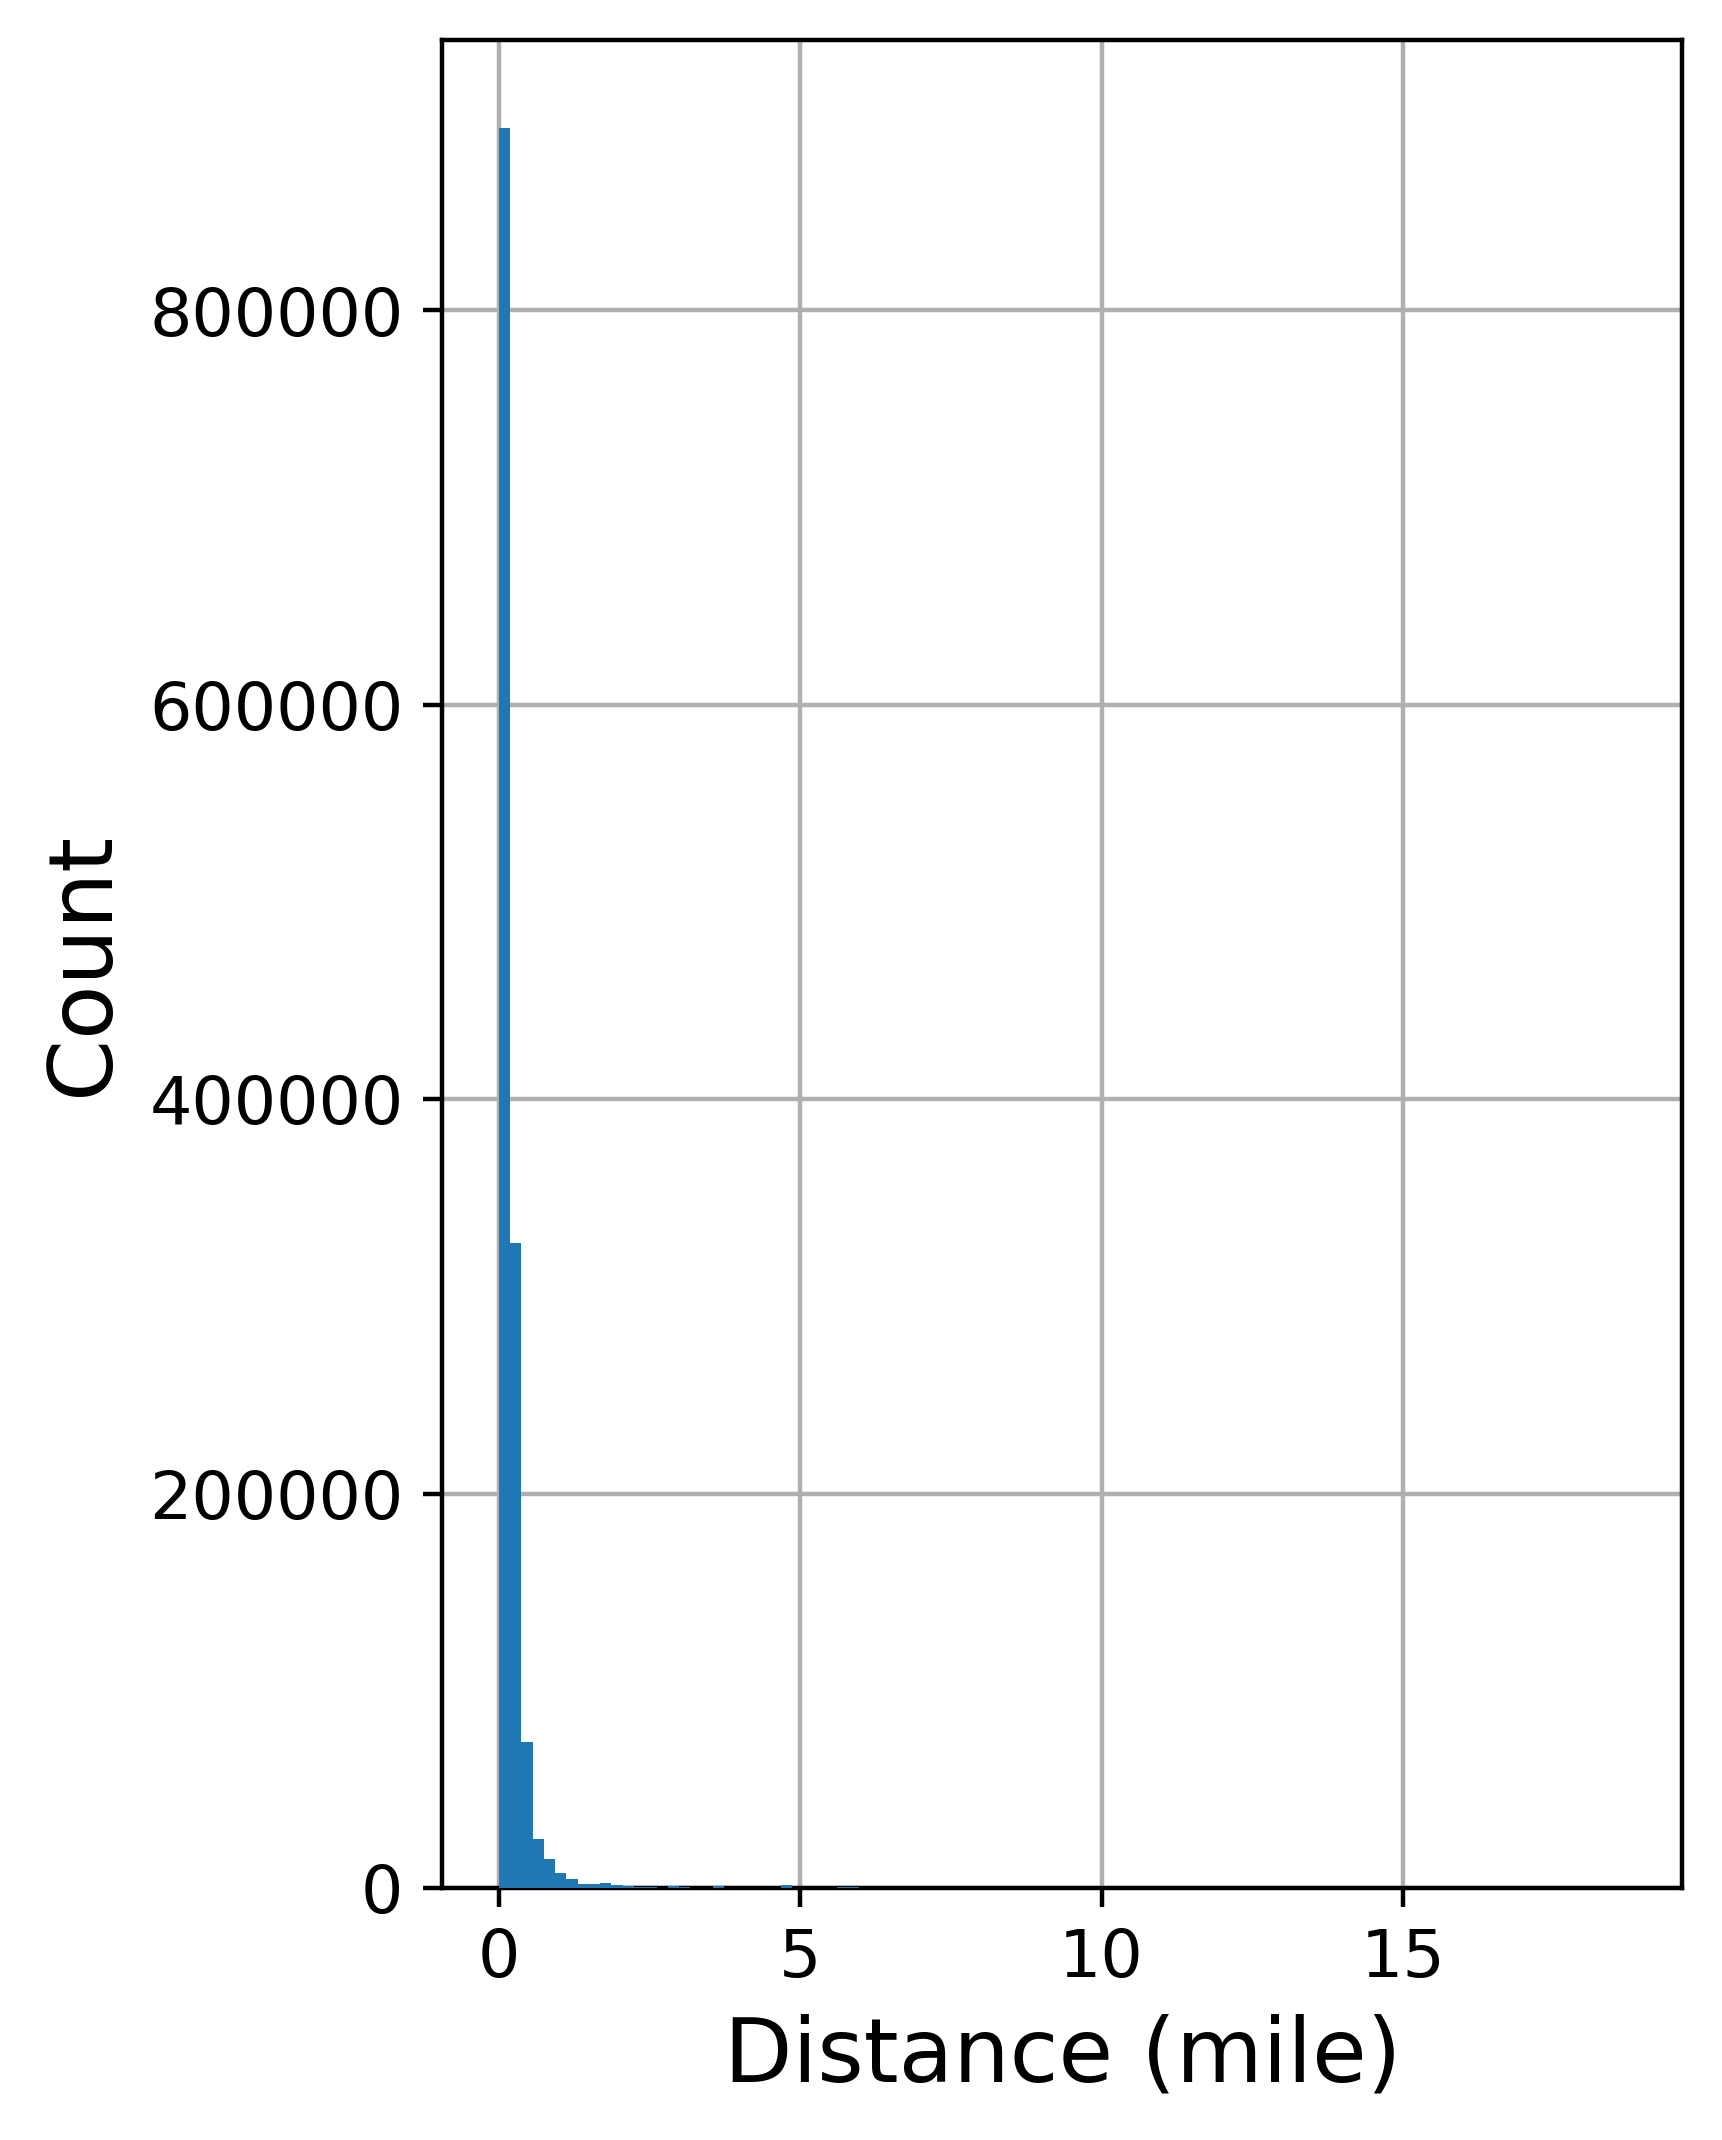

In [98]:
figure(figsize=(4 , 6), dpi=400)
ax=df_copy['dist'].hist(bins=100, zorder=3)
ax.set_xlabel('Distance (mile)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-distance.png', dpi=400, bbox_inches='tight')

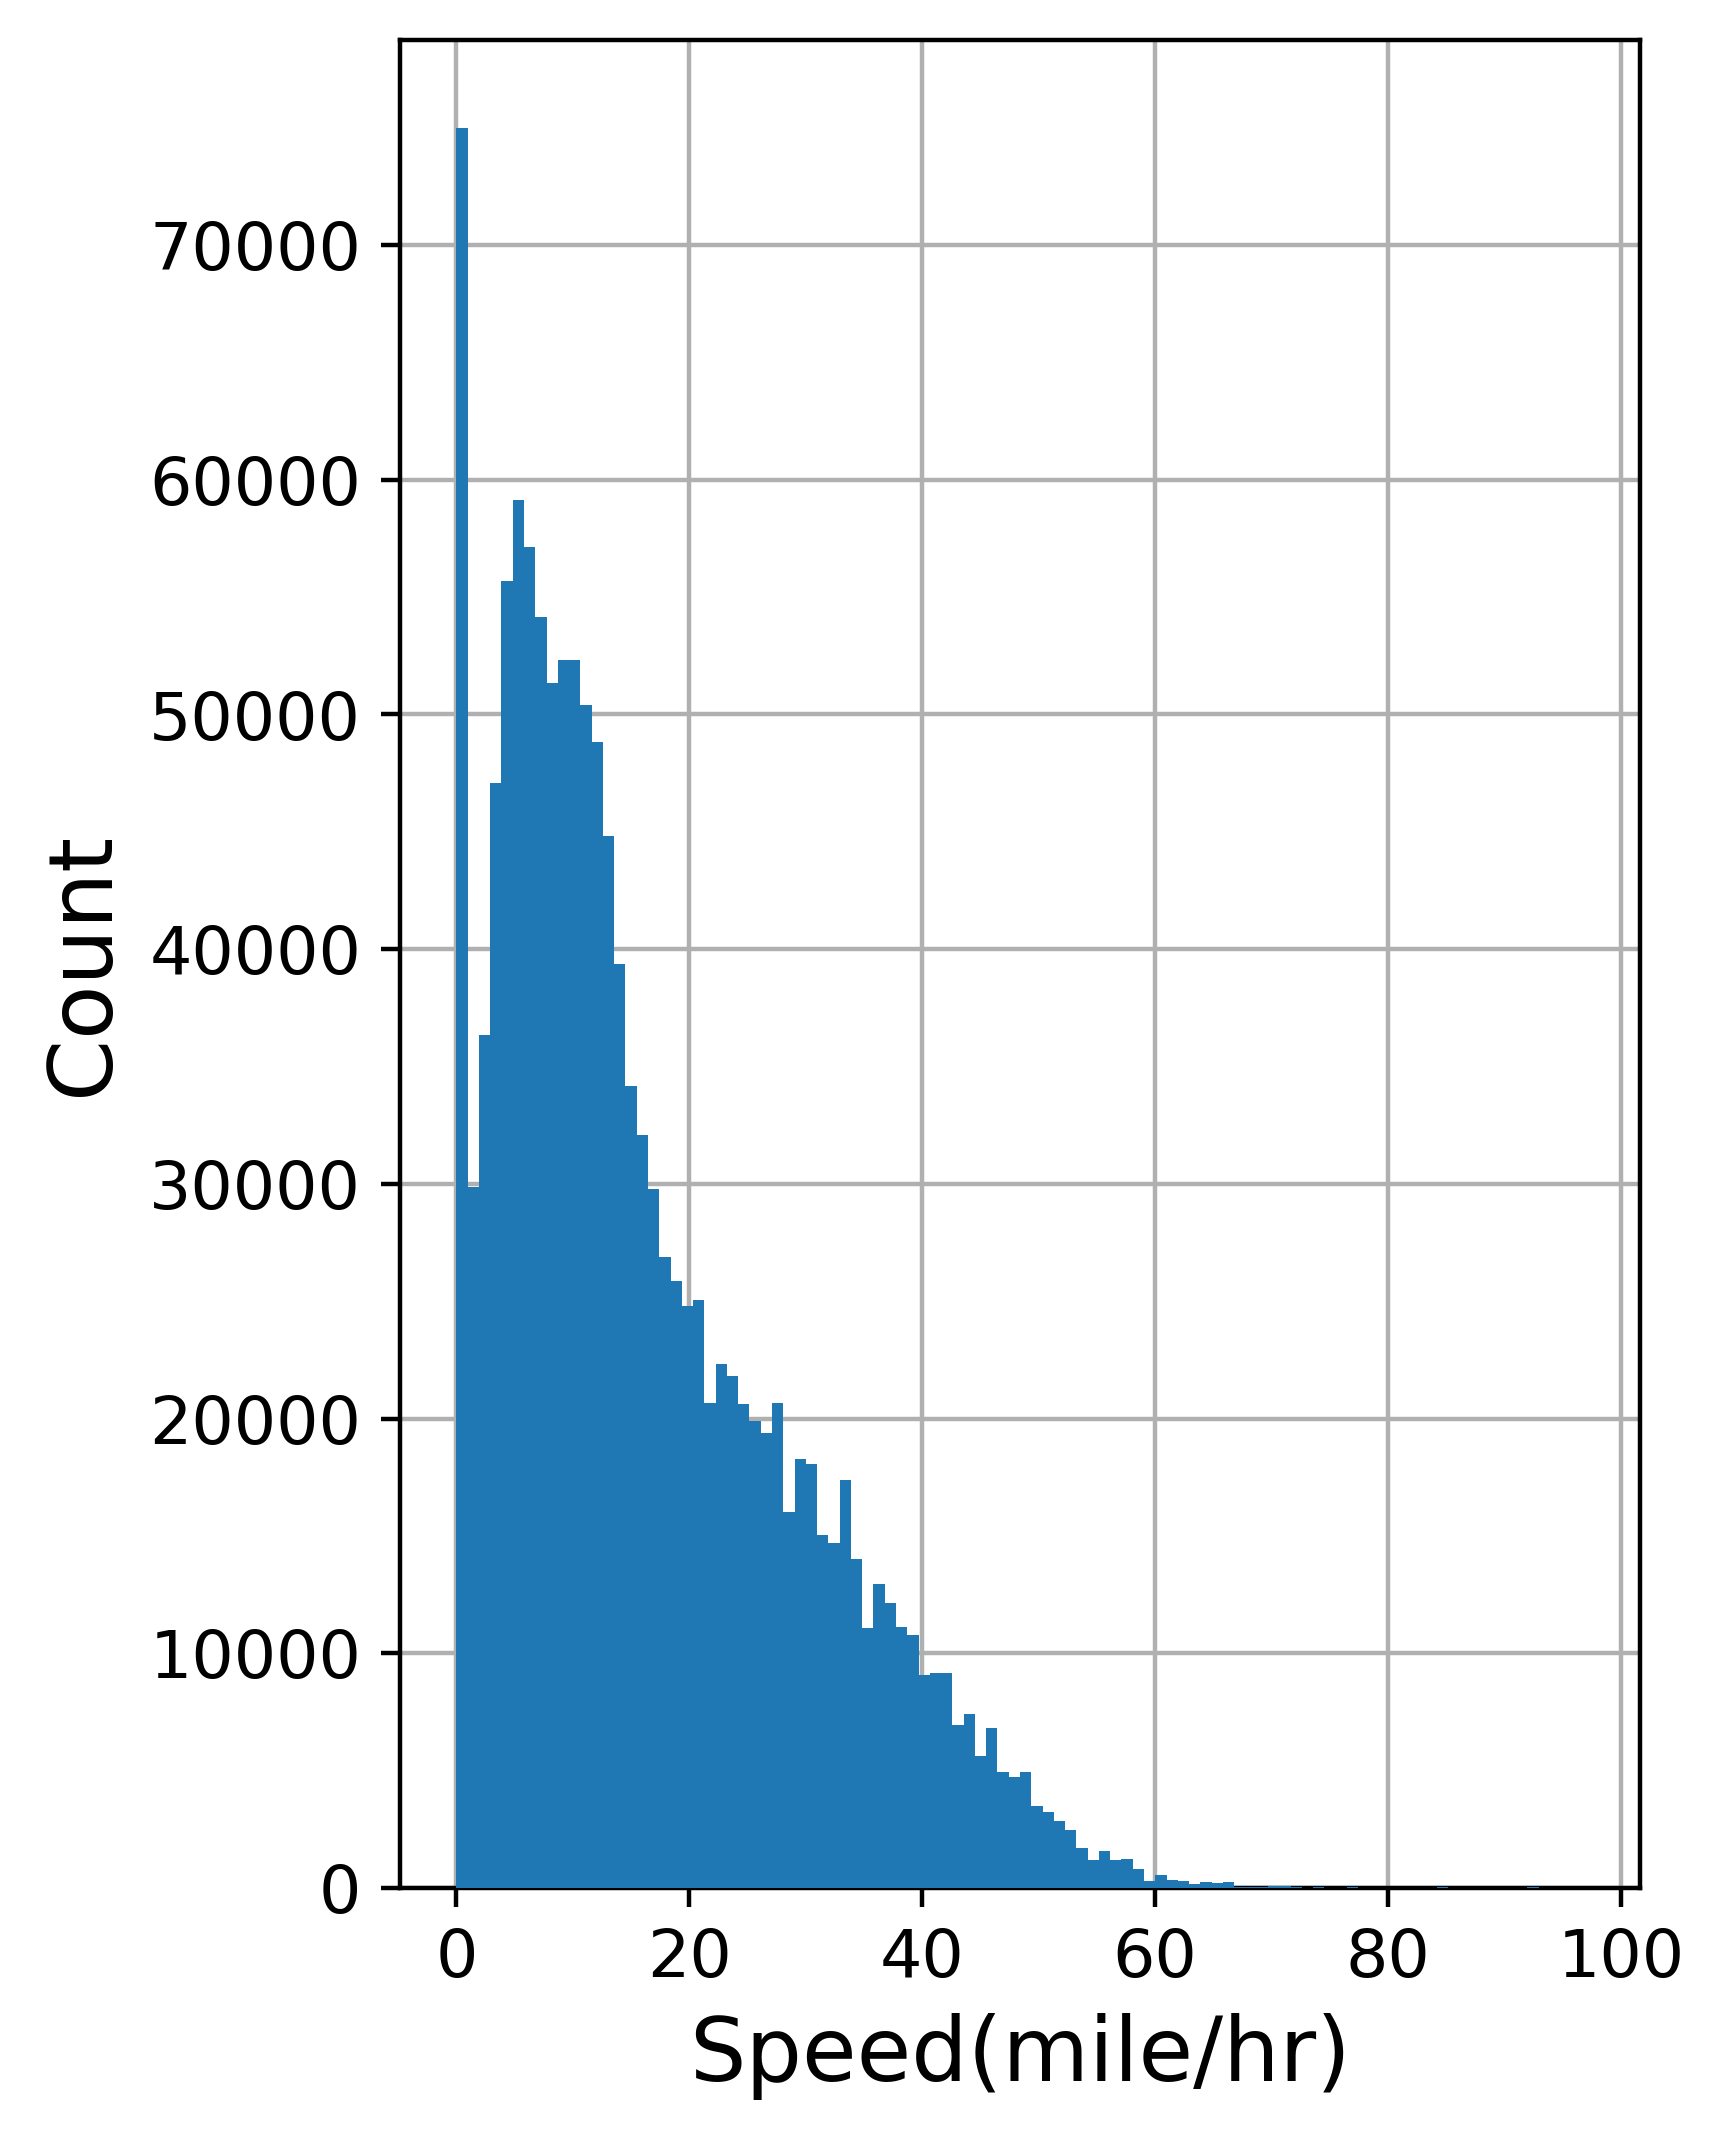

In [99]:
figure(figsize=(4 , 6), dpi=400)
ax=df_copy['speed'].hist(bins=100, zorder=3)
ax.set_xlabel('Speed(mile/hr)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-speed.png', dpi=400, bbox_inches='tight')

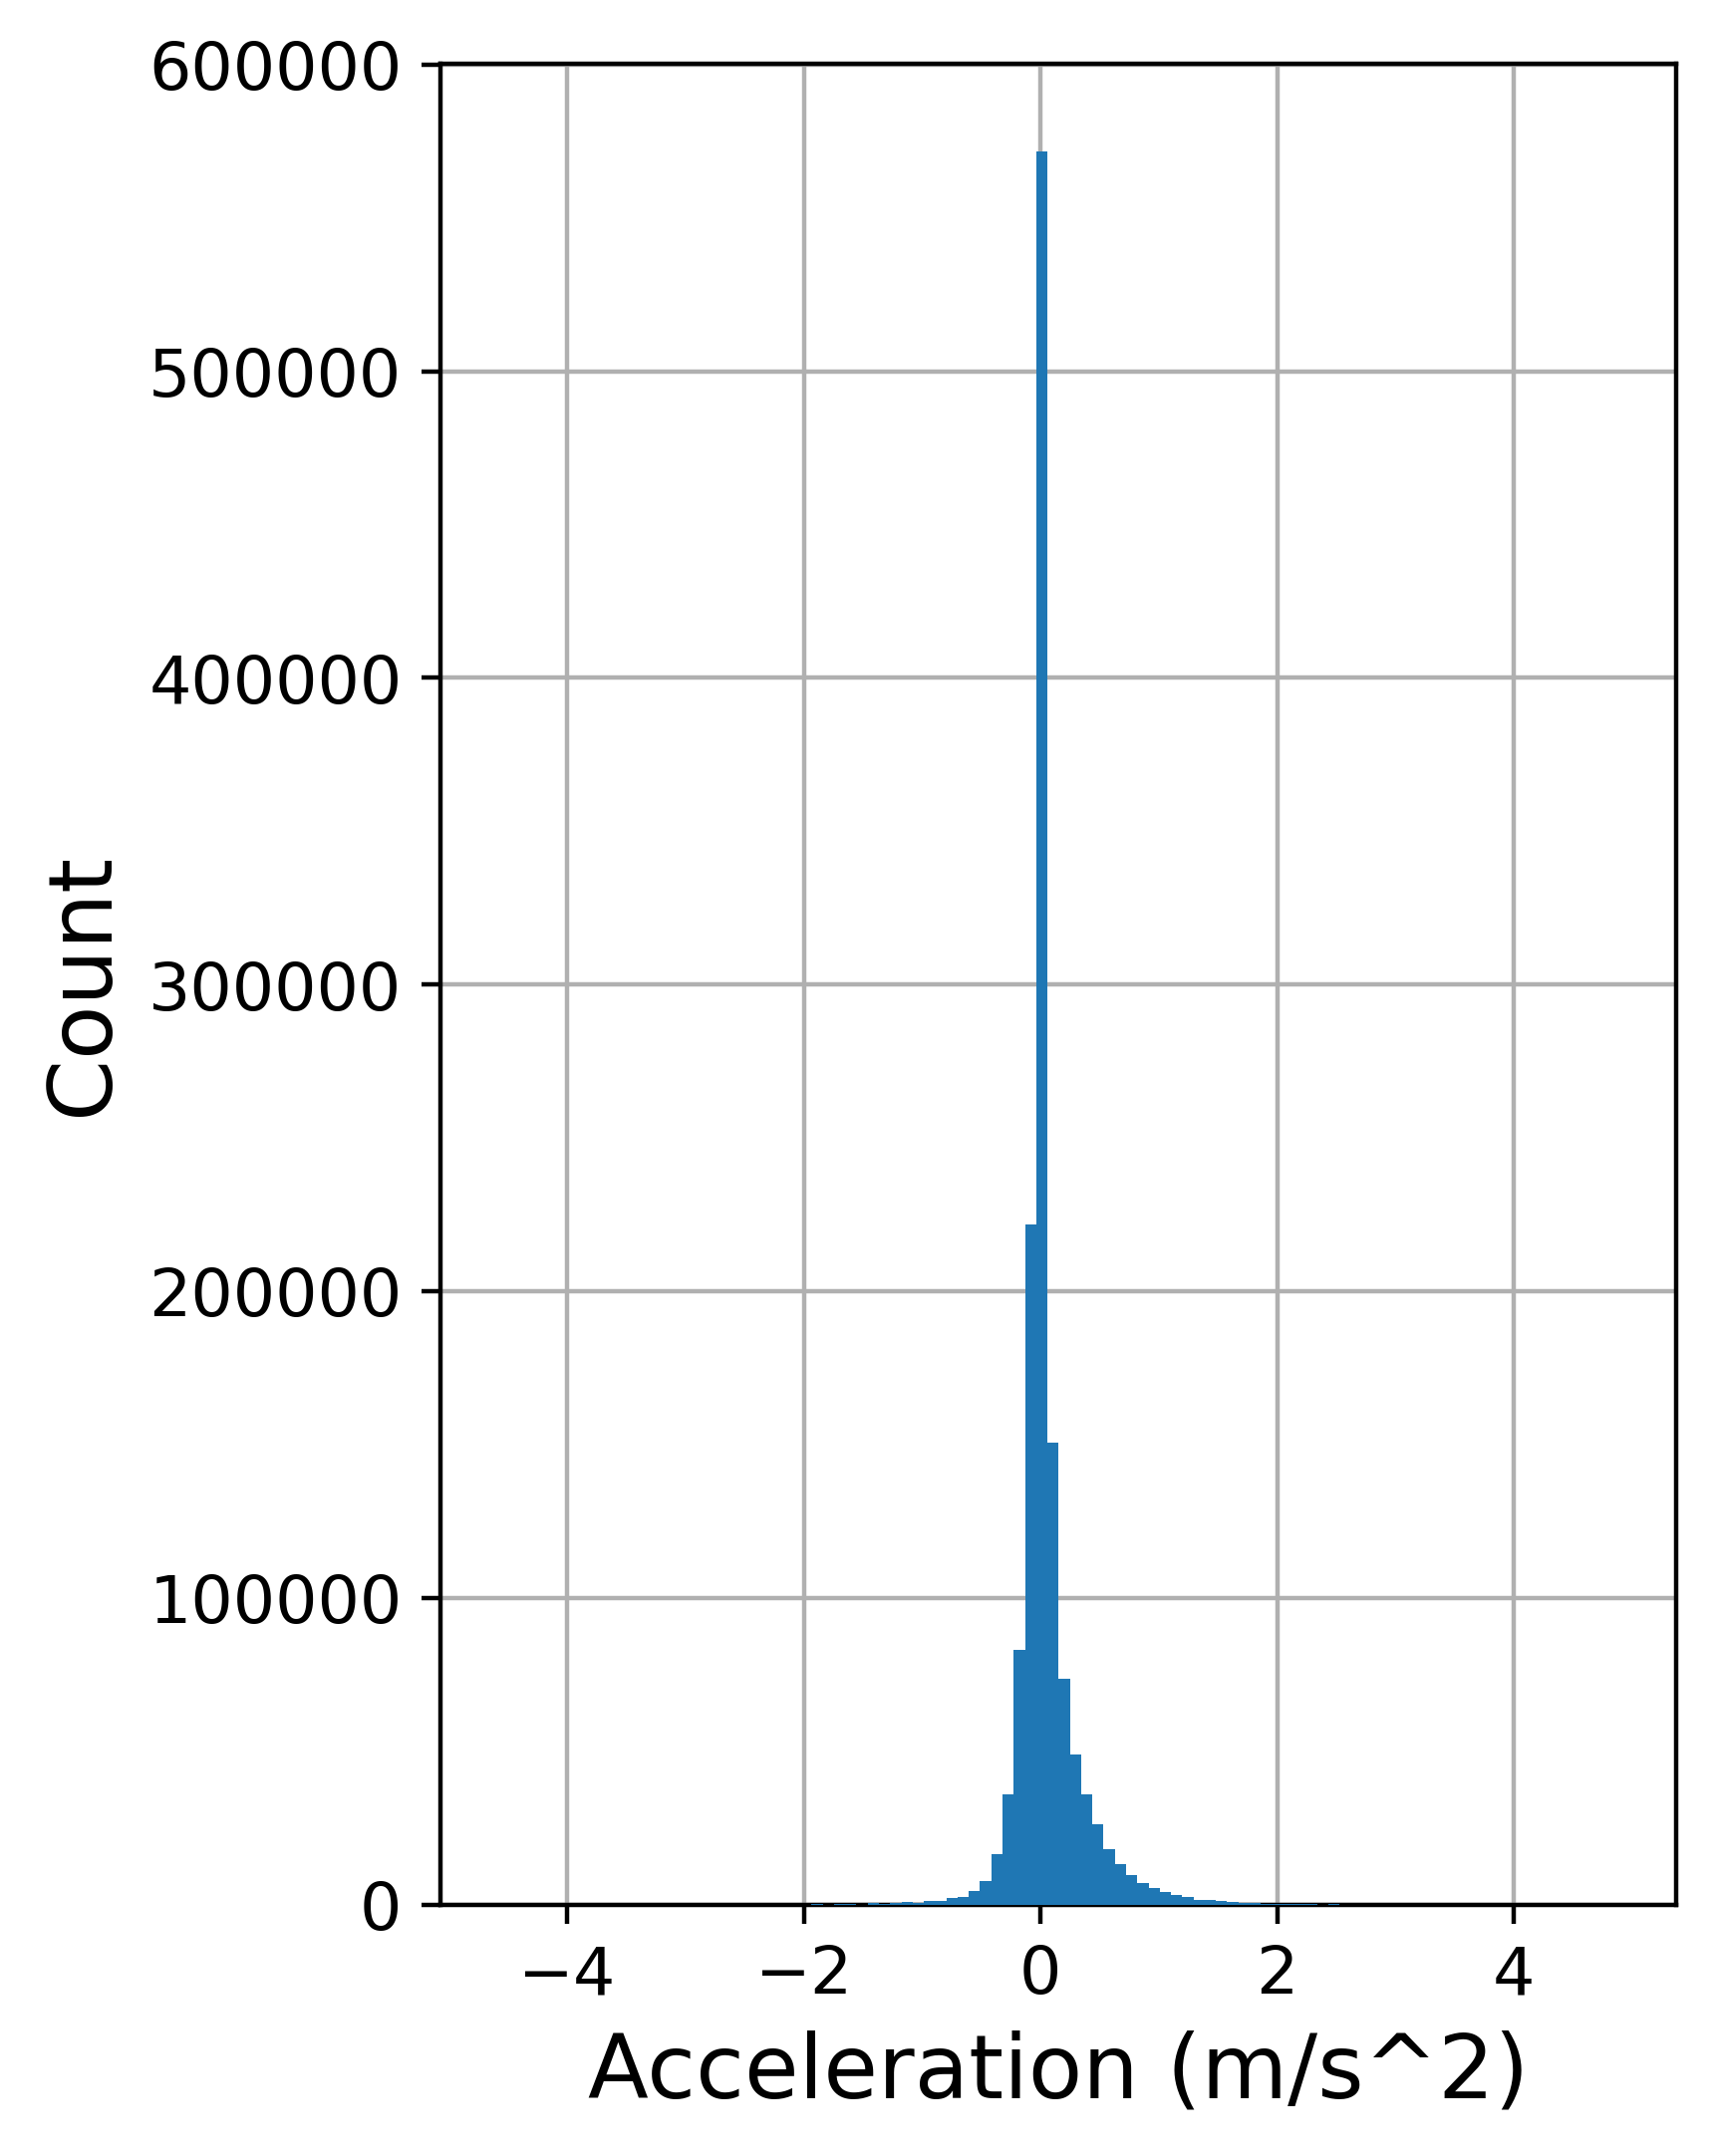

In [100]:
figure(figsize=(4, 6), dpi=400)
ax=df_copy['acc'].hist(bins=100, zorder=3)
ax.set_xlabel('Acceleration (m/s^2)', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(r'../../figures/hist-trajectories-acceleration.png', dpi=400, bbox_inches='tight')

In [103]:
ind_list = [13248, 13249,14215,14216,35589,35590,190041,190042,217628,217629,263794,263795,264966,264967,306983,306984,388110,388111,392564,392565,395360,395361,395477,395478,640284,640285,640286,749057,749058,822527,822528]
df_copy[['ServiceDateTime','Date','Vehicle','dist','speed','acc']].iloc[ind_list]

ServiceDateTime        Date  Vehicle      dist      speed       acc
13256  2022-04-12 15:04:57  2022-04-12     1412  0.072887  23.853890  0.621677
13257  2022-04-12 15:05:39  2022-04-12     1412  0.136468  11.697265 -0.129393
14224  2022-04-28 15:03:09  2022-04-28     1413  0.136468  11.982564 -0.089424
14225  2022-04-28 15:03:09  2022-04-28     1413  0.000000   0.000000  0.000000
35603  2022-04-13 06:28:08  2022-04-13     1552  0.522519  33.001188  0.116448
35604  2022-04-13 06:29:17  2022-04-13     1552  0.540296  28.189333 -0.031175
190104 2022-04-15 05:15:07  2022-04-15     1652  0.079310  35.689679  0.732855
190105 2022-04-15 05:16:09  2022-04-15     1652  0.246068  14.287840 -0.154314
217708 2022-04-28 11:14:39  2022-04-28     1654  0.332342  33.234249  0.147061
217709 2022-04-28 11:15:28  2022-04-28     1654  0.235301  17.287420 -0.145487
263904 2022-04-22 06:35:09  2022-04-22     1661  0.172403  10.344187 -0.046729
263905 2022-04-22 06:35:48  2022-04-22     1661  0.045485   4.198614 -0.070444
265081 2022-04-26 14:54:34  2022-04-26     1661  0.000000   0.000000  0.000000
265082 2022-04-26 15:07:34  2022-04-26     1661  6.326623  29.199798  0.016735
307118 2022-04-14 08:46:14  2022-04-14     1672  0.279692   5.355800  0.004437
307119 2022-04-14 08:47:33  2022-04-14     1672  0.264024  12.031481  0.037776
388267 2022-04-09 16:07:17  2022-04-09     1721  0.123533  29.647991 -0.332112
388268 2022-04-09 16:07:48  2022-04-09     1721  0.101975  11.842315 -0.256769
392721 2022-04-19 09:25:03  2022-04-19     1721  0.123407   7.659721 -0.045975
392722 2022-04-19 09:26:26  2022-04-19     1721  0.540296  23.434506  0.084963
395522 2022-04-25 18:16:46  2022-04-25     1721  0.120676  19.746950  0.161980
395523 2022-04-25 18:17:28  2022-04-25     1721  0.284990  24.427702  0.049821
395639 2022-04-26 11:06:28  2022-04-26     1721  0.446635  20.098563  0.084857
395640 2022-04-26 11:07:09  2022-04-26     1721  0.069327   6.087292 -0.152771
640516 2022-04-26 16:42:49  2022-04-26     1819  0.138492   5.601925 -0.081337
640517 2022-04-26 16:43:34  2022-04-26     1819  0.111960   8.956829  0.033328
640518 2022-04-26 16:44:26  2022-04-26     1819  0.158992  11.007164  0.017627
749329 2022-04-11 10:02:15  2022-04-11     1836  0.346855  22.703248 -0.087696
749330 2022-04-11 10:03:00  2022-04-11     1836  0.522353  41.788214  0.189594
822823 2022-04-25 11:08:21  2022-04-25     1844  0.352311  22.648580  0.052070
822824 2022-04-25 11:08:38  2022-04-25     1844  0.076102  16.115738 -0.171791

In [106]:
len(df_copy['Route'].unique())

49

In [107]:
len(df_copy['Operator'].unique())

3

In [108]:
df_copy['Route'].unique()

array(['R44', '(X) 39E', 'B43', '9999', '(X) P11', 'X92', '(X) 821',
       '(X) 804', '(X) 892', '(X) 823', '(X) 801', '(X) 820', 'G5',
       '(X) 802', 'X90', 'B4', 'R14', 'R10', 'G1', 'R29', 'B17', 'G3',
       '(X) 805', '(X) 824', '921', '(X) 803', 'G73', 'P20', 'P21', 'B6',
       'B7', 'G2', 'B12', '(X) 806', '(X) B9', 'B23', 'R24', '31', '30',
       '(X) 38', '33', '46', '45', '35', '(X) 34', 'R41', 'R42', 'B48',
       '(X) 943'], dtype=object)

In [109]:
trajectories = pd.read_csv(r'../../results/computed-trajectories2.csv', delimiter=',', skiprows=0, low_memory=False)

In [111]:
len(trajectories['Vehicle'].unique())

178

In [112]:
trajectories['ServiceDateTime']= pd.to_datetime(trajectories['ServiceDateTime'])

In [113]:
trajectories = trajectories.set_index("ServiceDateTime")
trajectories

Unnamed: 0.1  Unnamed: 0  DateKey  \
ServiceDateTime                                          
2022-04-04 06:43:24             0      112564     8763   
2022-04-04 06:51:27             1      109326     8763   
2022-04-04 06:51:27             2      112565     8763   
2022-04-04 06:52:52             3      109327     8763   
2022-04-04 06:54:33             4      109328     8763   
...                           ...         ...      ...   
2022-04-30 23:54:20       1361544     1325566     8789   
2022-04-30 23:55:24       1361545     1325567     8789   
2022-04-30 23:56:47       1361546     1325568     8789   
2022-04-30 23:57:32       1361547     1325569     8789   
2022-04-30 23:59:29       1361548     1325570     8789   

                                CalendarDate  Year  Month  OpKey Operator  \
ServiceDateTime                                                             
2022-04-04 06:43:24  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:52:52  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:54:33  2022-04-04 00:00:00.000  2022      4      1    VATCo   
...                                      ...   ...    ...    ...      ...   
2022-04-30 23:54:20  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:55:24  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:56:47  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:57:32  2022-04-30 00:00:00.000  2022      4      1    VATCo   
2022-04-30 23:59:29  2022-04-30 00:00:00.000  2022      4      1    VATCo   

                     RtKey  RtKey2  ... Minute Second        Date  Daytype  \
ServiceDateTime                     ...                                      
2022-04-04 06:43:24   3519    1006  ...     43     24  2022-04-04  Weekday   
2022-04-04 06:51:27   3513    3380  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:51:27   3519    1006  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:52:52   3513    3380  ...     52     52  2022-04-04  Weekday   
2022-04-04 06:54:33   3513    3380  ...     54     33  2022-04-04  Weekday   
...                    ...     ...  ...    ...    ...         ...      ...   
2022-04-30 23:54:20   3515    1001  ...     54     20  2022-04-30  Weekend   
2022-04-30 23:55:24   3515    1001  ...     55     24  2022-04-30  Weekend   
2022-04-30 23:56:47   3515    1001  ...     56     47  2022-04-30  Weekend   
2022-04-30 23:57:32   3515    1001  ...     57     32  2022-04-30  Weekend   
2022-04-30 23:59:29   3515    1001  ...     59     29  2022-04-30  Weekend   

                         time           time_delta time_delta_in_seconds  \
ServiceDateTime                                                            
2022-04-04 06:43:24  06:43:24                  NaN                   NaN   
2022-04-04 06:51:27  06:51:27  2022-12-07 00:08:03                 483.0   
2022-04-04 06:51:27  06:51:27  2022-12-07 00:00:00                   0.0   
2022-04-04 06:52:52  06:52:52  2022-12-07 00:01:25                  85.0   
2022-04-04 06:54:33  06:54:33  2022-12-07 00:01:41                 101.0   
...                       ...                  ...                   ...   
2022-04-30 23:54:20  23:54:20  2022-12-07 00:02:20                 140.0   
2022-04-30 23:55:24  23:55:24  2022-12-07 00:01:04                  64.0   
2022-04-30 23:56:47  23:56:47  2022-12-07 00:01:23                  83.0   
2022-04-30 23:57:32  23:57:32  2022-12-07 00:00:45                  45.0   
2022-04-30 23:59:29  23:59:29  2022-12-07 00:01:57                 117.0   

                         dist      speed       acc  
ServiceDateTime                                     
2022-04-04 06:43:24  0.000000   0.000000  0.000000  
2022-04-04 06:51:27  0.627342   0.000000  0.000000  
2022-04-04 06:51:27  0.000000   0.000000  0.0000

In [114]:
selected_date=['2022-04-04']
plot_data=trajectories.loc[trajectories.Date.isin(selected_date)]

In [115]:
plot_data

Unnamed: 0.1  Unnamed: 0  DateKey  \
ServiceDateTime                                          
2022-04-04 06:43:24             0      112564     8763   
2022-04-04 06:51:27             1      109326     8763   
2022-04-04 06:51:27             2      112565     8763   
2022-04-04 06:52:52             3      109327     8763   
2022-04-04 06:54:33             4      109328     8763   
...                           ...         ...      ...   
2022-04-04 19:00:30       1348358      111110     8763   
2022-04-04 19:01:28       1348359      111111     8763   
2022-04-04 19:02:59       1348360      111112     8763   
2022-04-04 19:05:54       1348361      109322     8763   
2022-04-04 19:05:54       1348362      111113     8763   

                                CalendarDate  Year  Month  OpKey Operator  \
ServiceDateTime                                                             
2022-04-04 06:43:24  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:51:27  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:52:52  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 06:54:33  2022-04-04 00:00:00.000  2022      4      1    VATCo   
...                                      ...   ...    ...    ...      ...   
2022-04-04 19:00:30  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:01:28  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:02:59  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:05:54  2022-04-04 00:00:00.000  2022      4      1    VATCo   
2022-04-04 19:05:54  2022-04-04 00:00:00.000  2022      4      1    VATCo   

                     RtKey  RtKey2  ... Minute Second        Date  Daytype  \
ServiceDateTime                     ...                                      
2022-04-04 06:43:24   3519    1006  ...     43     24  2022-04-04  Weekday   
2022-04-04 06:51:27   3513    3380  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:51:27   3519    1006  ...     51     27  2022-04-04  Weekday   
2022-04-04 06:52:52   3513    3380  ...     52     52  2022-04-04  Weekday   
2022-04-04 06:54:33   3513    3380  ...     54     33  2022-04-04  Weekday   
...                    ...     ...  ...    ...    ...         ...      ...   
2022-04-04 19:00:30   3515    1001  ...      0     30  2022-04-04  Weekday   
2022-04-04 19:01:28   3515    1001  ...      1     28  2022-04-04  Weekday   
2022-04-04 19:02:59   3515    1001  ...      2     59  2022-04-04  Weekday   
2022-04-04 19:05:54   3410    1007  ...      5     54  2022-04-04  Weekday   
2022-04-04 19:05:54   3515    1001  ...      5     54  2022-04-04  Weekday   

                         time           time_delta time_delta_in_seconds  \
ServiceDateTime                                                            
2022-04-04 06:43:24  06:43:24                  NaN                   NaN   
2022-04-04 06:51:27  06:51:27  2022-12-07 00:08:03                 483.0   
2022-04-04 06:51:27  06:51:27  2022-12-07 00:00:00                   0.0   
2022-04-04 06:52:52  06:52:52  2022-12-07 00:01:25                  85.0   
2022-04-04 06:54:33  06:54:33  2022-12-07 00:01:41                 101.0   
...                       ...                  ...                   ...   
2022-04-04 19:00:30  19:00:30  2022-12-07 00:02:14                 134.0   
2022-04-04 19:01:28  19:01:28  2022-12-07 00:00:58                  58.0   
2022-04-04 19:02:59  19:02:59  2022-12-07 00:01:31                  91.0   
2022-04-04 19:05:54  19:05:54  2022-12-07 00:02:55                 175.0   
2022-04-04 19:05:54  19:05:54  2022-12-07 00:00:00                   0.0   

                         dist      speed       acc  
ServiceDateTime                                     
2022-04-04 06:43:24  0.000000   0.000000  0.000000  
2022-04-04 06:51:27  0.627342   0.000000  0.000000  
2022-04-04 06:51:27  0.000000   0.000000  0.0000

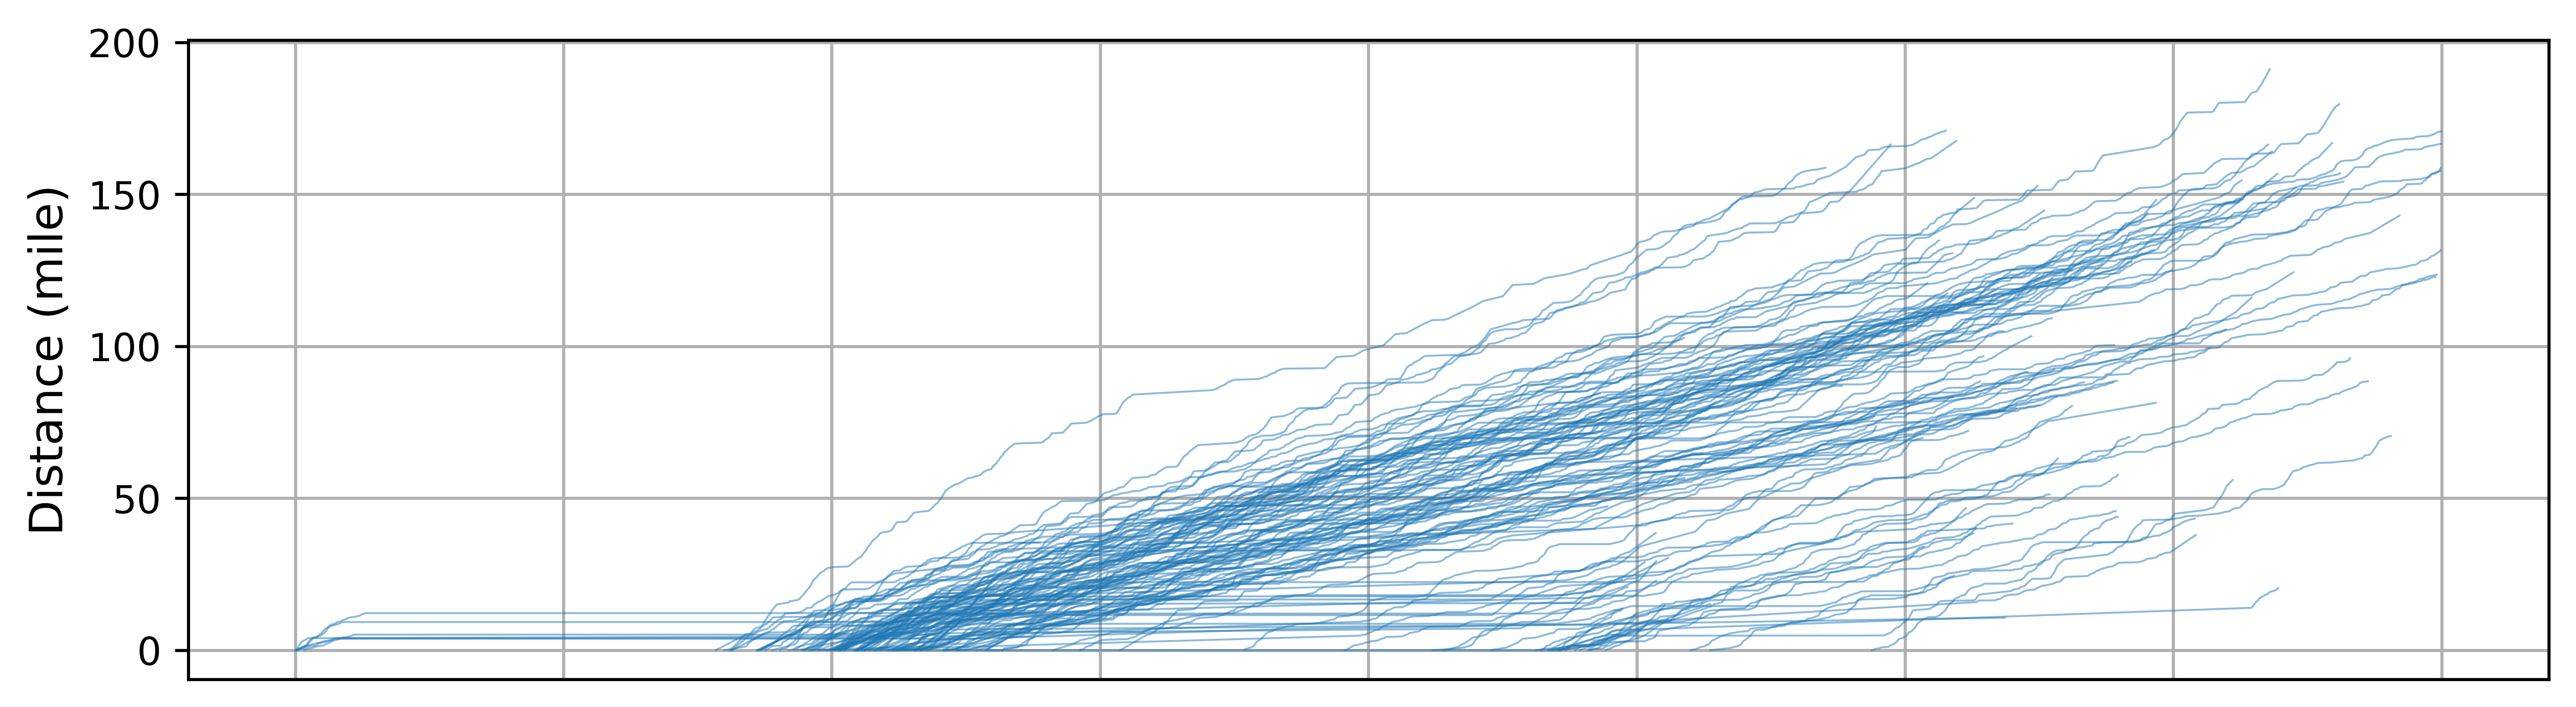

In [116]:
# set size

figure(figsize=(11, 3), dpi=600)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["dist"].cumsum(), marker='', color='#1f77b4', linewidth=0.5, alpha=0.5)

# Remove x-ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Labelling 

#plt.xlabel("time")
plt.ylabel("Distance (mile)", fontsize=12)
#plt.title("Pandas Time Series Plot")
plt.yticks(fontsize=10)
plt.grid()


# Saving
plt.savefig(r'../../figures/trajectories-distance.png', dpi=600, bbox_inches='tight')


# Display

plt.show()

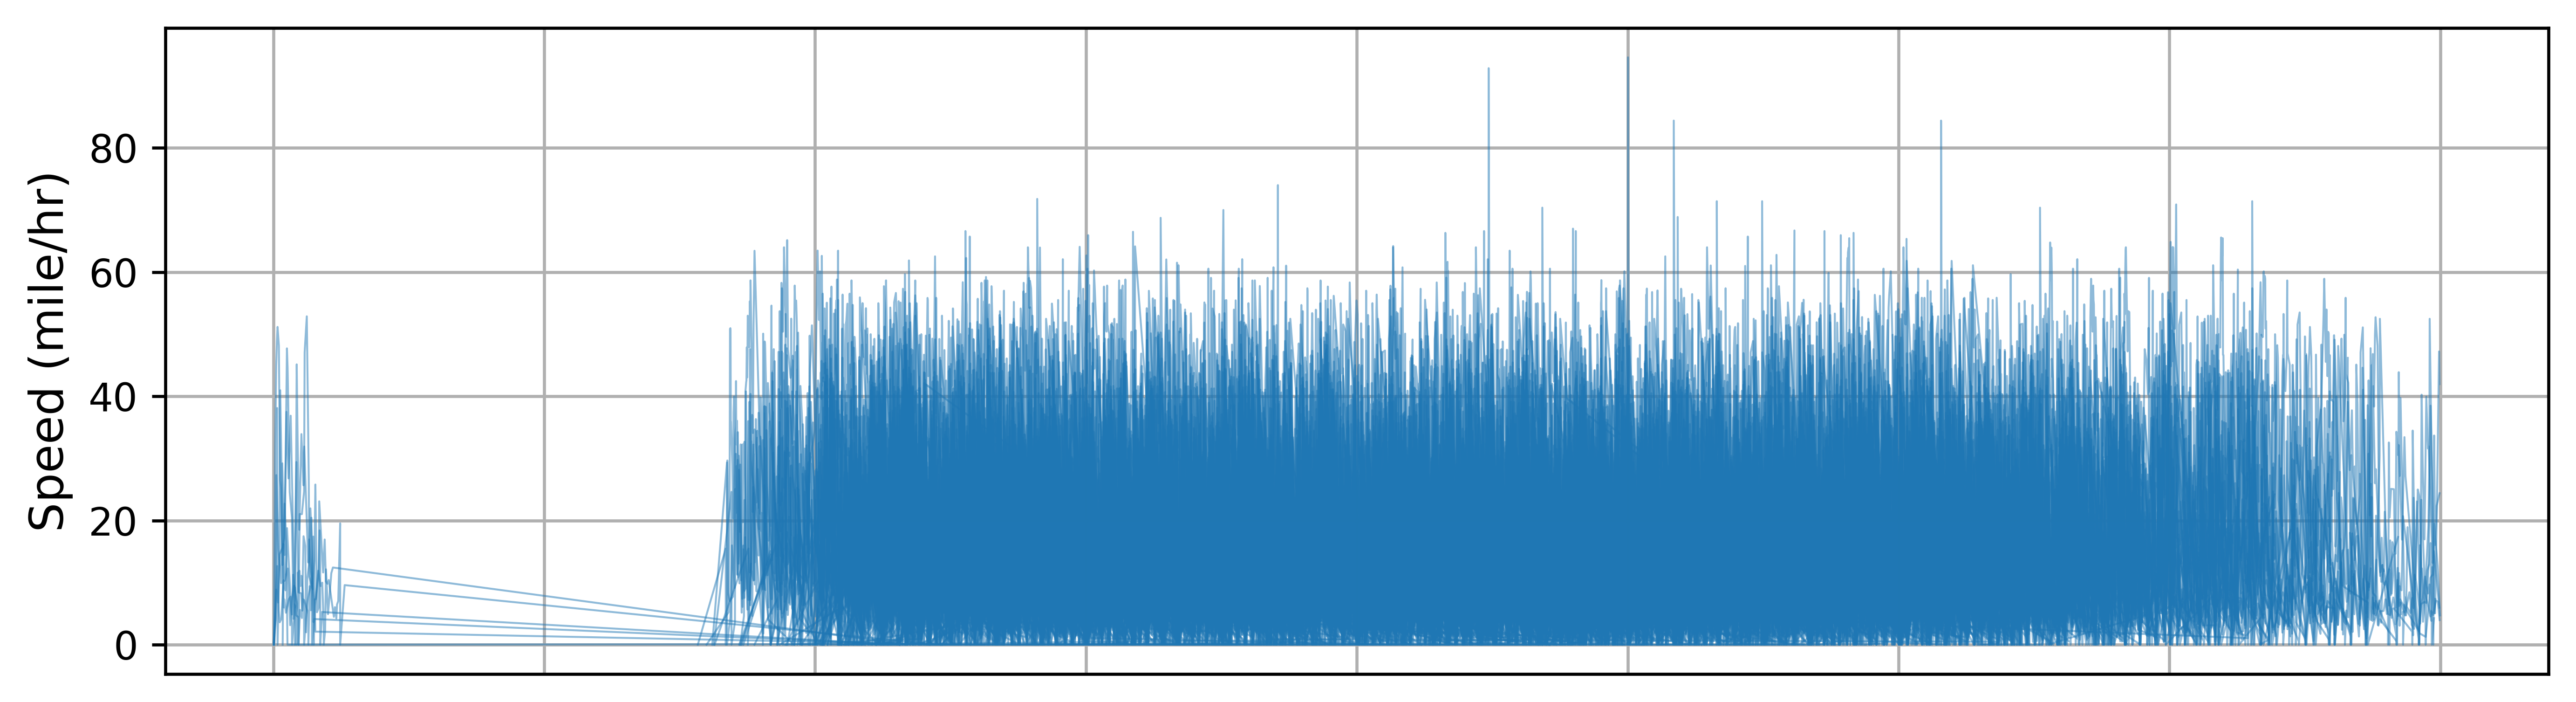

In [117]:
# set size

figure(figsize=(11, 3), dpi=600)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["speed"], marker='',color='#1f77b4', linewidth=0.5, alpha=0.5)



# Remove x-ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Labelling 

#plt.xlabel("time")
plt.ylabel("Speed (mile/hr)", fontsize=12)
plt.yticks(fontsize=10)
#plt.title("Pandas Time Series Plot")
plt.grid()

# Saving
plt.savefig(r'../../figures/trajectories-speed.png', dpi=600, bbox_inches='tight')

# Display

plt.show()

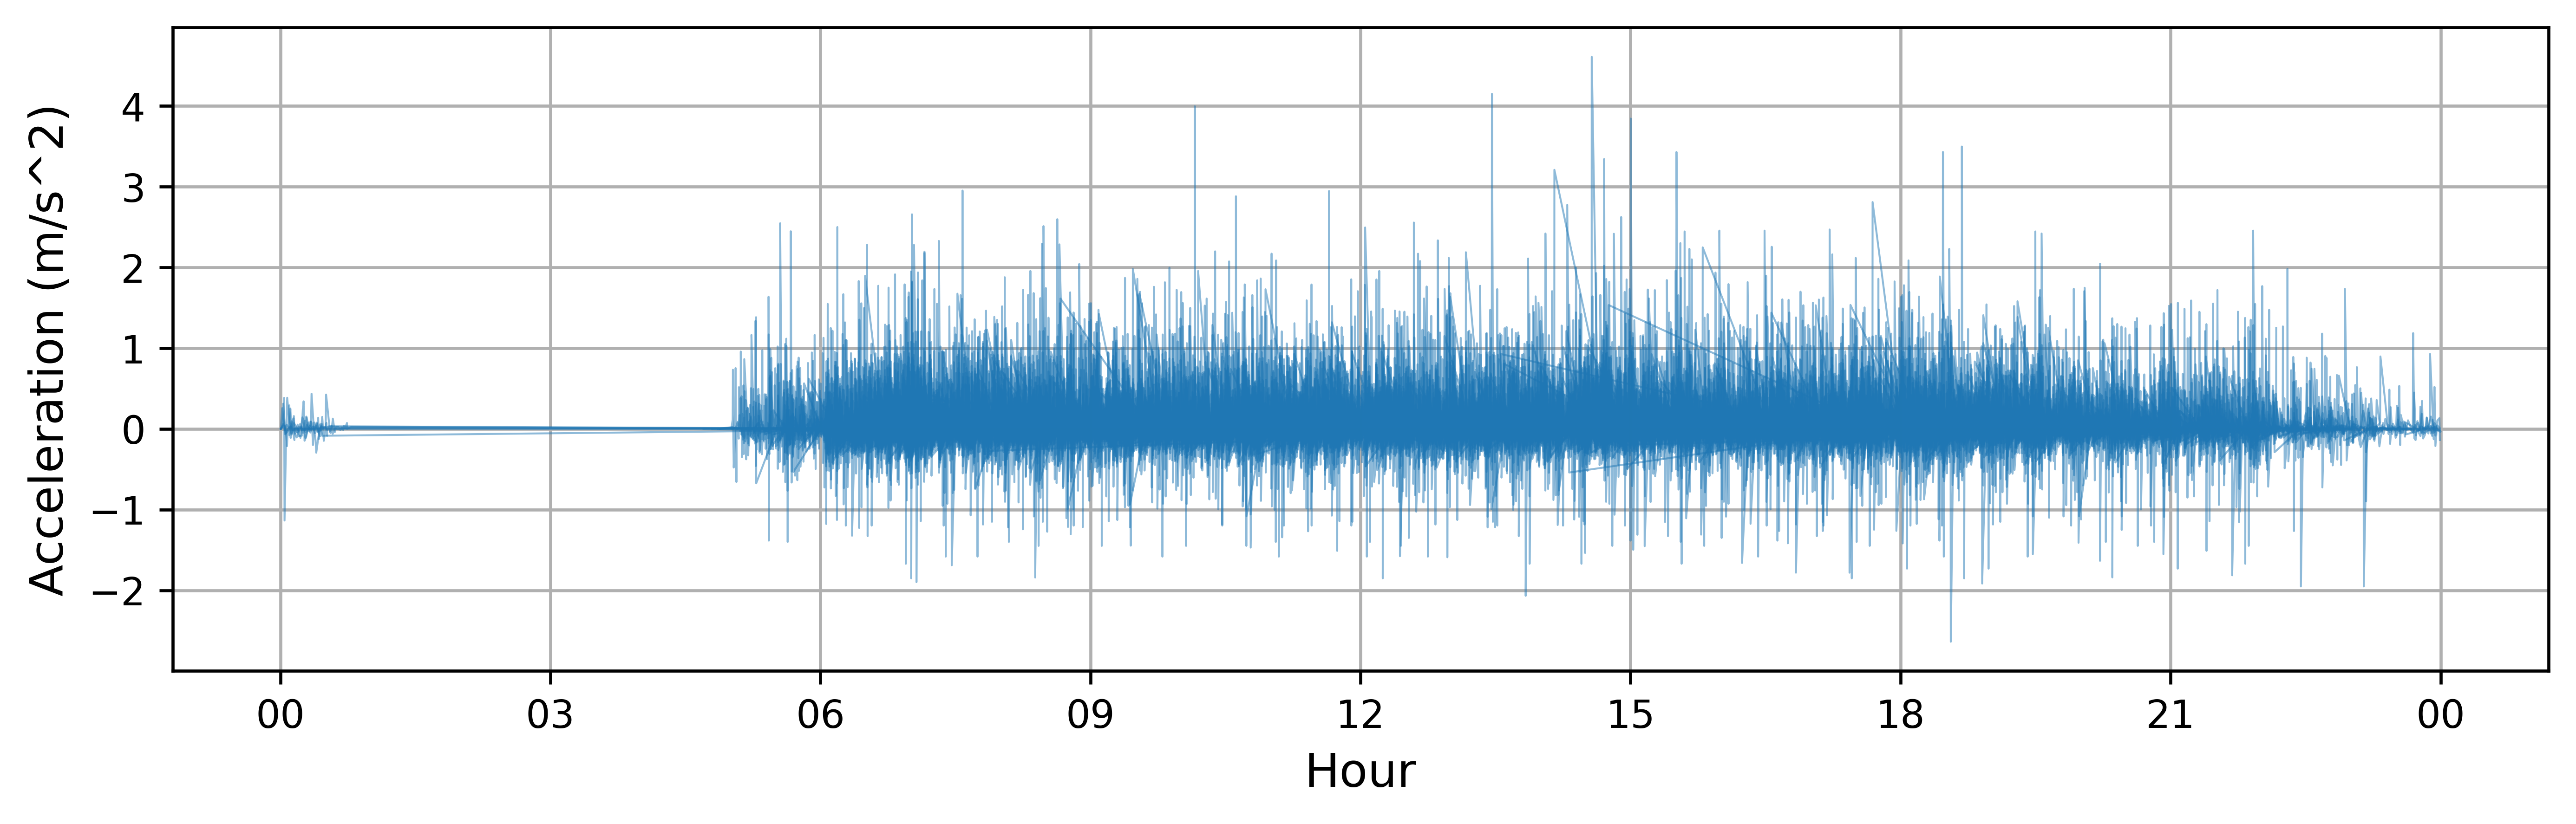

In [118]:
# set size
fig, ax = plt.subplots(figsize=(11, 3), dpi=600)
#figure(figsize=(11, 4), dpi=400)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["acc"], marker='', color='#1f77b4', linewidth=0.5, alpha=0.5)


# Labelling 

#plt.xlabel("time")
plt.ylabel("Acceleration (m/s^2)", fontsize=12)
plt.xlabel("Hour", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.title("Pandas Time Series Plot")
plt.grid()

date_form = DateFormatter("%H")
ax.xaxis.set_major_formatter(date_form)

# Saving
plt.savefig(r'../../figures/trajectories-acceleration.png', dpi=600, bbox_inches='tight')

# Display

plt.show()

In [119]:
trajectories=trajectories.reset_index()
trajectories.head()

ServiceDateTime  Unnamed: 0.1  Unnamed: 0  DateKey  \
0 2022-04-04 06:43:24             0      112564     8763   
1 2022-04-04 06:51:27             1      109326     8763   
2 2022-04-04 06:51:27             2      112565     8763   
3 2022-04-04 06:52:52             3      109327     8763   
4 2022-04-04 06:54:33             4      109328     8763   

              CalendarDate  Year  Month  OpKey Operator  RtKey  ...  Minute  \
0  2022-04-04 00:00:00.000  2022      4      1    VATCo   3519  ...      43   
1  2022-04-04 00:00:00.000  2022      4      1    VATCo   3513  ...      51   
2  2022-04-04 00:00:00.000  2022      4      1    VATCo   3519  ...      51   
3  2022-04-04 00:00:00.000  2022      4      1    VATCo   3513  ...      52   
4  2022-04-04 00:00:00.000  2022      4      1    VATCo   3513  ...      54   

  Second        Date  Daytype      time           time_delta  \
0     24  2022-04-04  Weekday  06:43:24                  NaN   
1     27  2022-04-04  Weekday  06:51:27  2022-12-07 00:08:03   
2     27  2022-04-04  Weekday  06:51:27  2022-12-07 00:00:00   
3     52  2022-04-04  Weekday  06:52:52  2022-12-07 00:01:25   
4     33  2022-04-04  Weekday  06:54:33  2022-12-07 00:01:41   

   time_delta_in_seconds      dist      speed       acc  
0                    NaN  0.000000   0.000000  0.000000  
1                  483.0  0.627342   0.000000  0.000000  
2                    0.0  0.000000   0.000000  0.000000  
3                   85.0  0.313431  13.274729  0.069816  
4                  101.0  0.421734  15.032101  0.007778  

[5 rows x 41 columns]

In [120]:
trajectories.sort_values(by=['ServiceDateTime','Vehicle'], ascending=True, inplace=True)

In [121]:
trajectories['Vehicle']

1061662    3303
1346193    7901
1174432    3317
1212942    3322
1212943    3322
           ... 
1245233    3325
1056837    3301
1360786    7902
1031098    3222
1245234    3325
Name: Vehicle, Length: 1360787, dtype: int64

In [122]:
trajectories['time_delta'] = trajectories.groupby(['Vehicle', 'Date'])['ServiceDateTime'].diff()

In [123]:
trajectories['time_delta'].max()

Timedelta('0 days 20:26:36')

In [124]:
trajectories['time_delta'].median()

Timedelta('0 days 00:00:41')

In [125]:
trajectories['time_delta'].min()

Timedelta('0 days 00:00:00')

In [126]:
trajectories['time_delta'].unique()

array([         'NaT',              0,    17000000000, ...,
       12664000000000,  3338000000000, 56031000000000],
      dtype='timedelta64[ns]')

In [351]:
#trajectories.time_delta=trajectories.time_delta.astype(str).str.replace('0 days ', '')

In [352]:
#trajectories['time_delta']= pd.to_datetime(trajectories['time_delta'])

In [353]:
#trajectories['time_delta_in_seconds'] = trajectories['time_delta'].dt.hour * 3600 + trajectories['time_delta'].dt.minute * 60 + trajectories['time_delta'].dt.second

In [354]:
trajectories['time_delta_in_seconds'].unique()

array([       nan, 0.0000e+00, 1.7000e+01, ..., 1.2664e+04, 3.3380e+03,
       5.6031e+04])

In [355]:
trajectories.head()

ServiceDateTime  Unnamed: 0.1  Unnamed: 0  DateKey  \
1061897 2022-04-01 00:00:00       1062086       46929     8760   
1346649 2022-04-01 00:00:08       1346943        2437     8760   
1174744 2022-04-01 00:00:12       1174966       46955     8760   
1213270 2022-04-01 00:00:18       1213526       48367     8760   
1213271 2022-04-01 00:00:18       1213527       50425     8760   

                    CalendarDate  Year  Month  OpKey Operator  RtKey  ...  \
1061897  2022-04-01 00:00:00.000  2022      4      3    UMASS   3505  ...   
1346649  2022-04-01 00:00:00.000  2022      4      1    VATCo   3515  ...   
1174744  2022-04-01 00:00:00.000  2022      4      3    UMASS   3505  ...   
1213270  2022-04-01 00:00:00.000  2022      4      3    UMASS   3508  ...   
1213271  2022-04-01 00:00:00.000  2022      4      3    UMASS   3508  ...   

         Minute Second        Date  Daytype      time  time_delta  \
1061897       0      0  2022-04-01  Weekday  00:00:00         NaT   
1346649       0      8  2022-04-01  Weekday  00:00:08         NaT   
1174744       0     12  2022-04-01  Weekday  00:00:12         NaT   
1213270       0     18  2022-04-01  Weekday  00:00:18         NaT   
1213271       0     18  2022-04-01  Weekday  00:00:18      0 days   

         time_delta_in_seconds dist  speed  acc  
1061897                    NaN  0.0    0.0  0.0  
1346649                    NaN  0.0    0.0  0.0  
1174744                    NaN  0.0    0.0  0.0  
1213270                    NaN  0.0    0.0  0.0  
1213271                    0.0  0.0    0.0  0.0  

[5 rows x 41 columns]

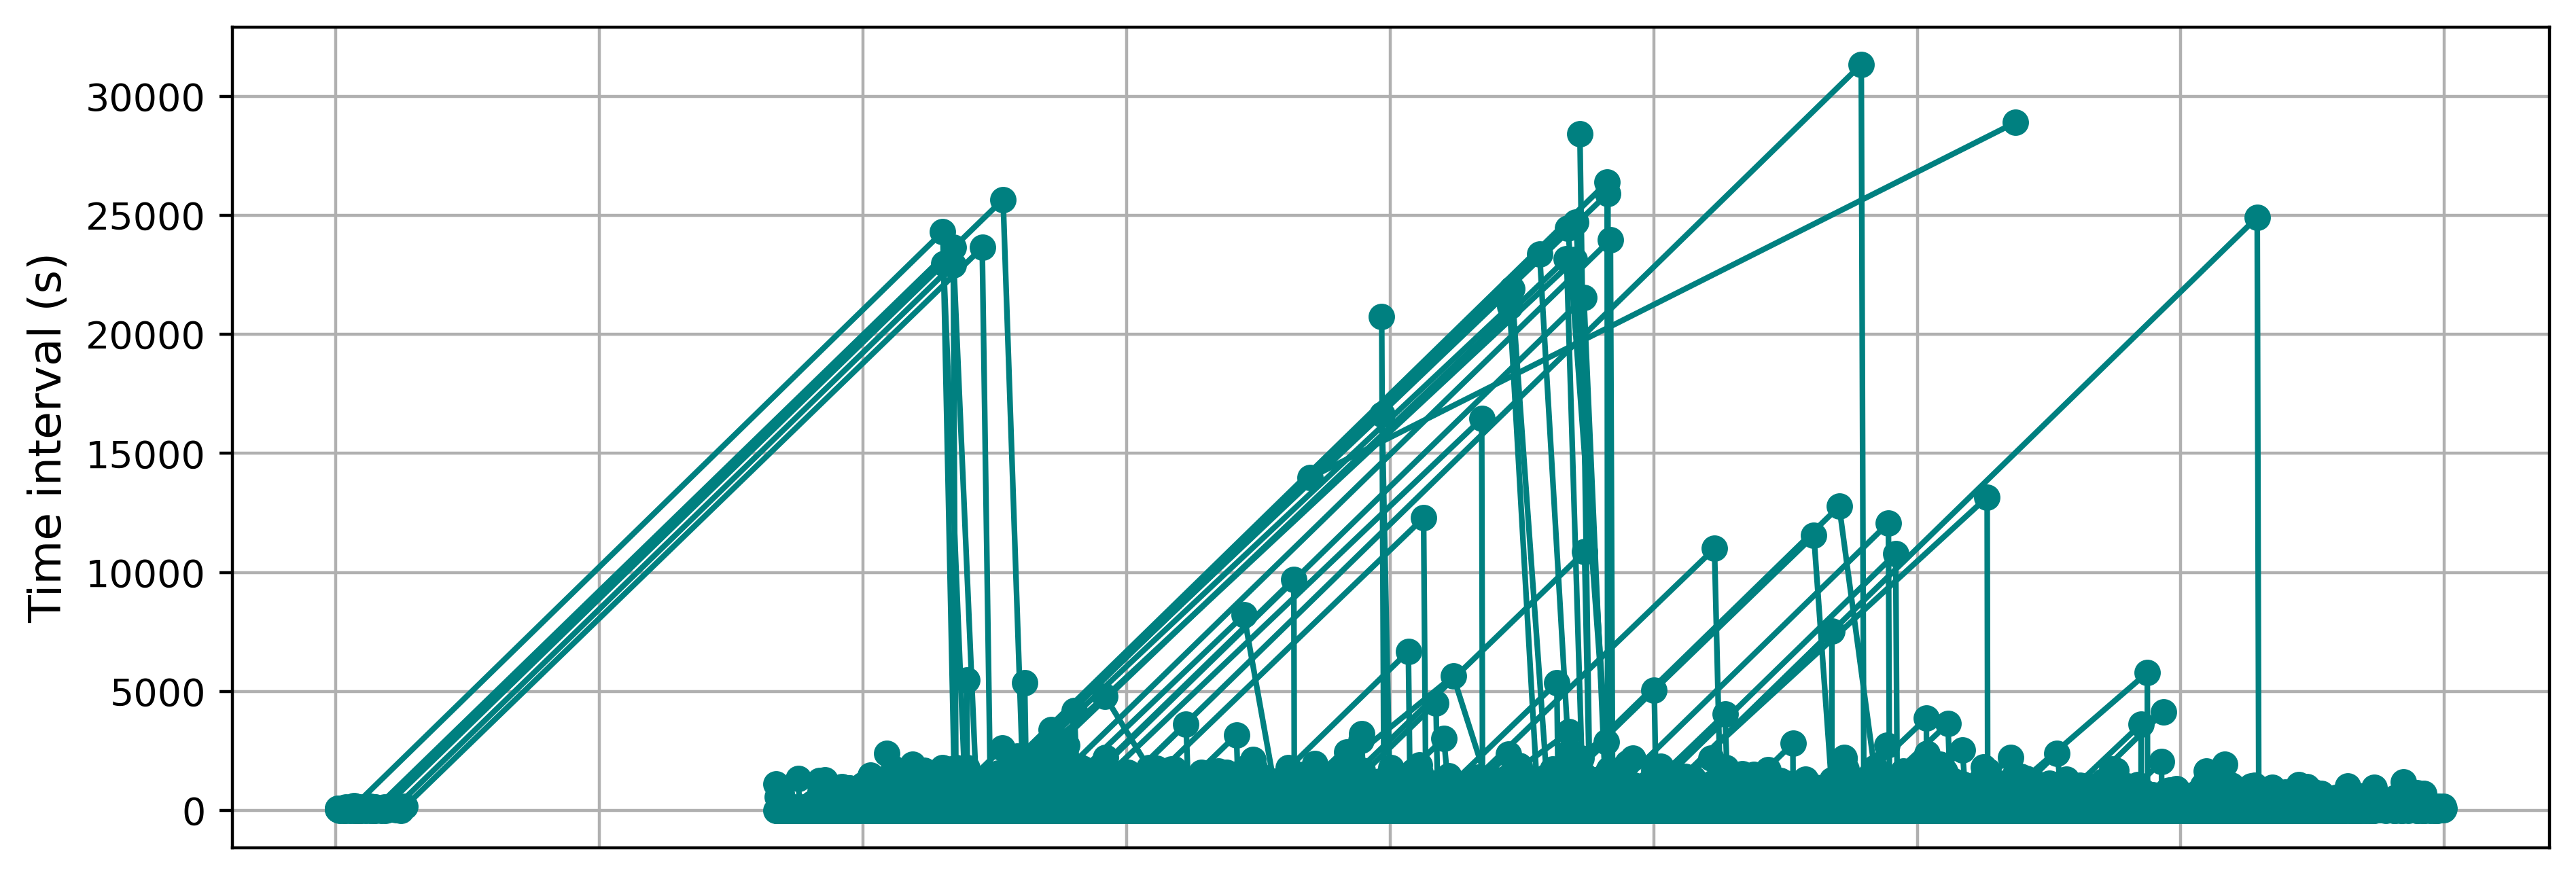

In [312]:
# set size

figure(figsize=(11, 4), dpi=400)

# Plot
vehicle=plot_data['Vehicle'].unique()
for v in vehicle:
    plot_df=plot_data[plot_data['Vehicle']==v]
    plt.plot(plot_df["time_delta_in_seconds"], marker='o', color='teal')



# Remove x-ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

# Labelling 

#plt.xlabel("time")
plt.ylabel("Time interval (s)", fontsize=12)
plt.yticks(fontsize=10)
#plt.title("Pandas Time Series Plot")
plt.grid()

# Saving
plt.savefig(r'../../figures/time-intervals.png', dpi=400, bbox_inches='tight')

# Display

plt.show()

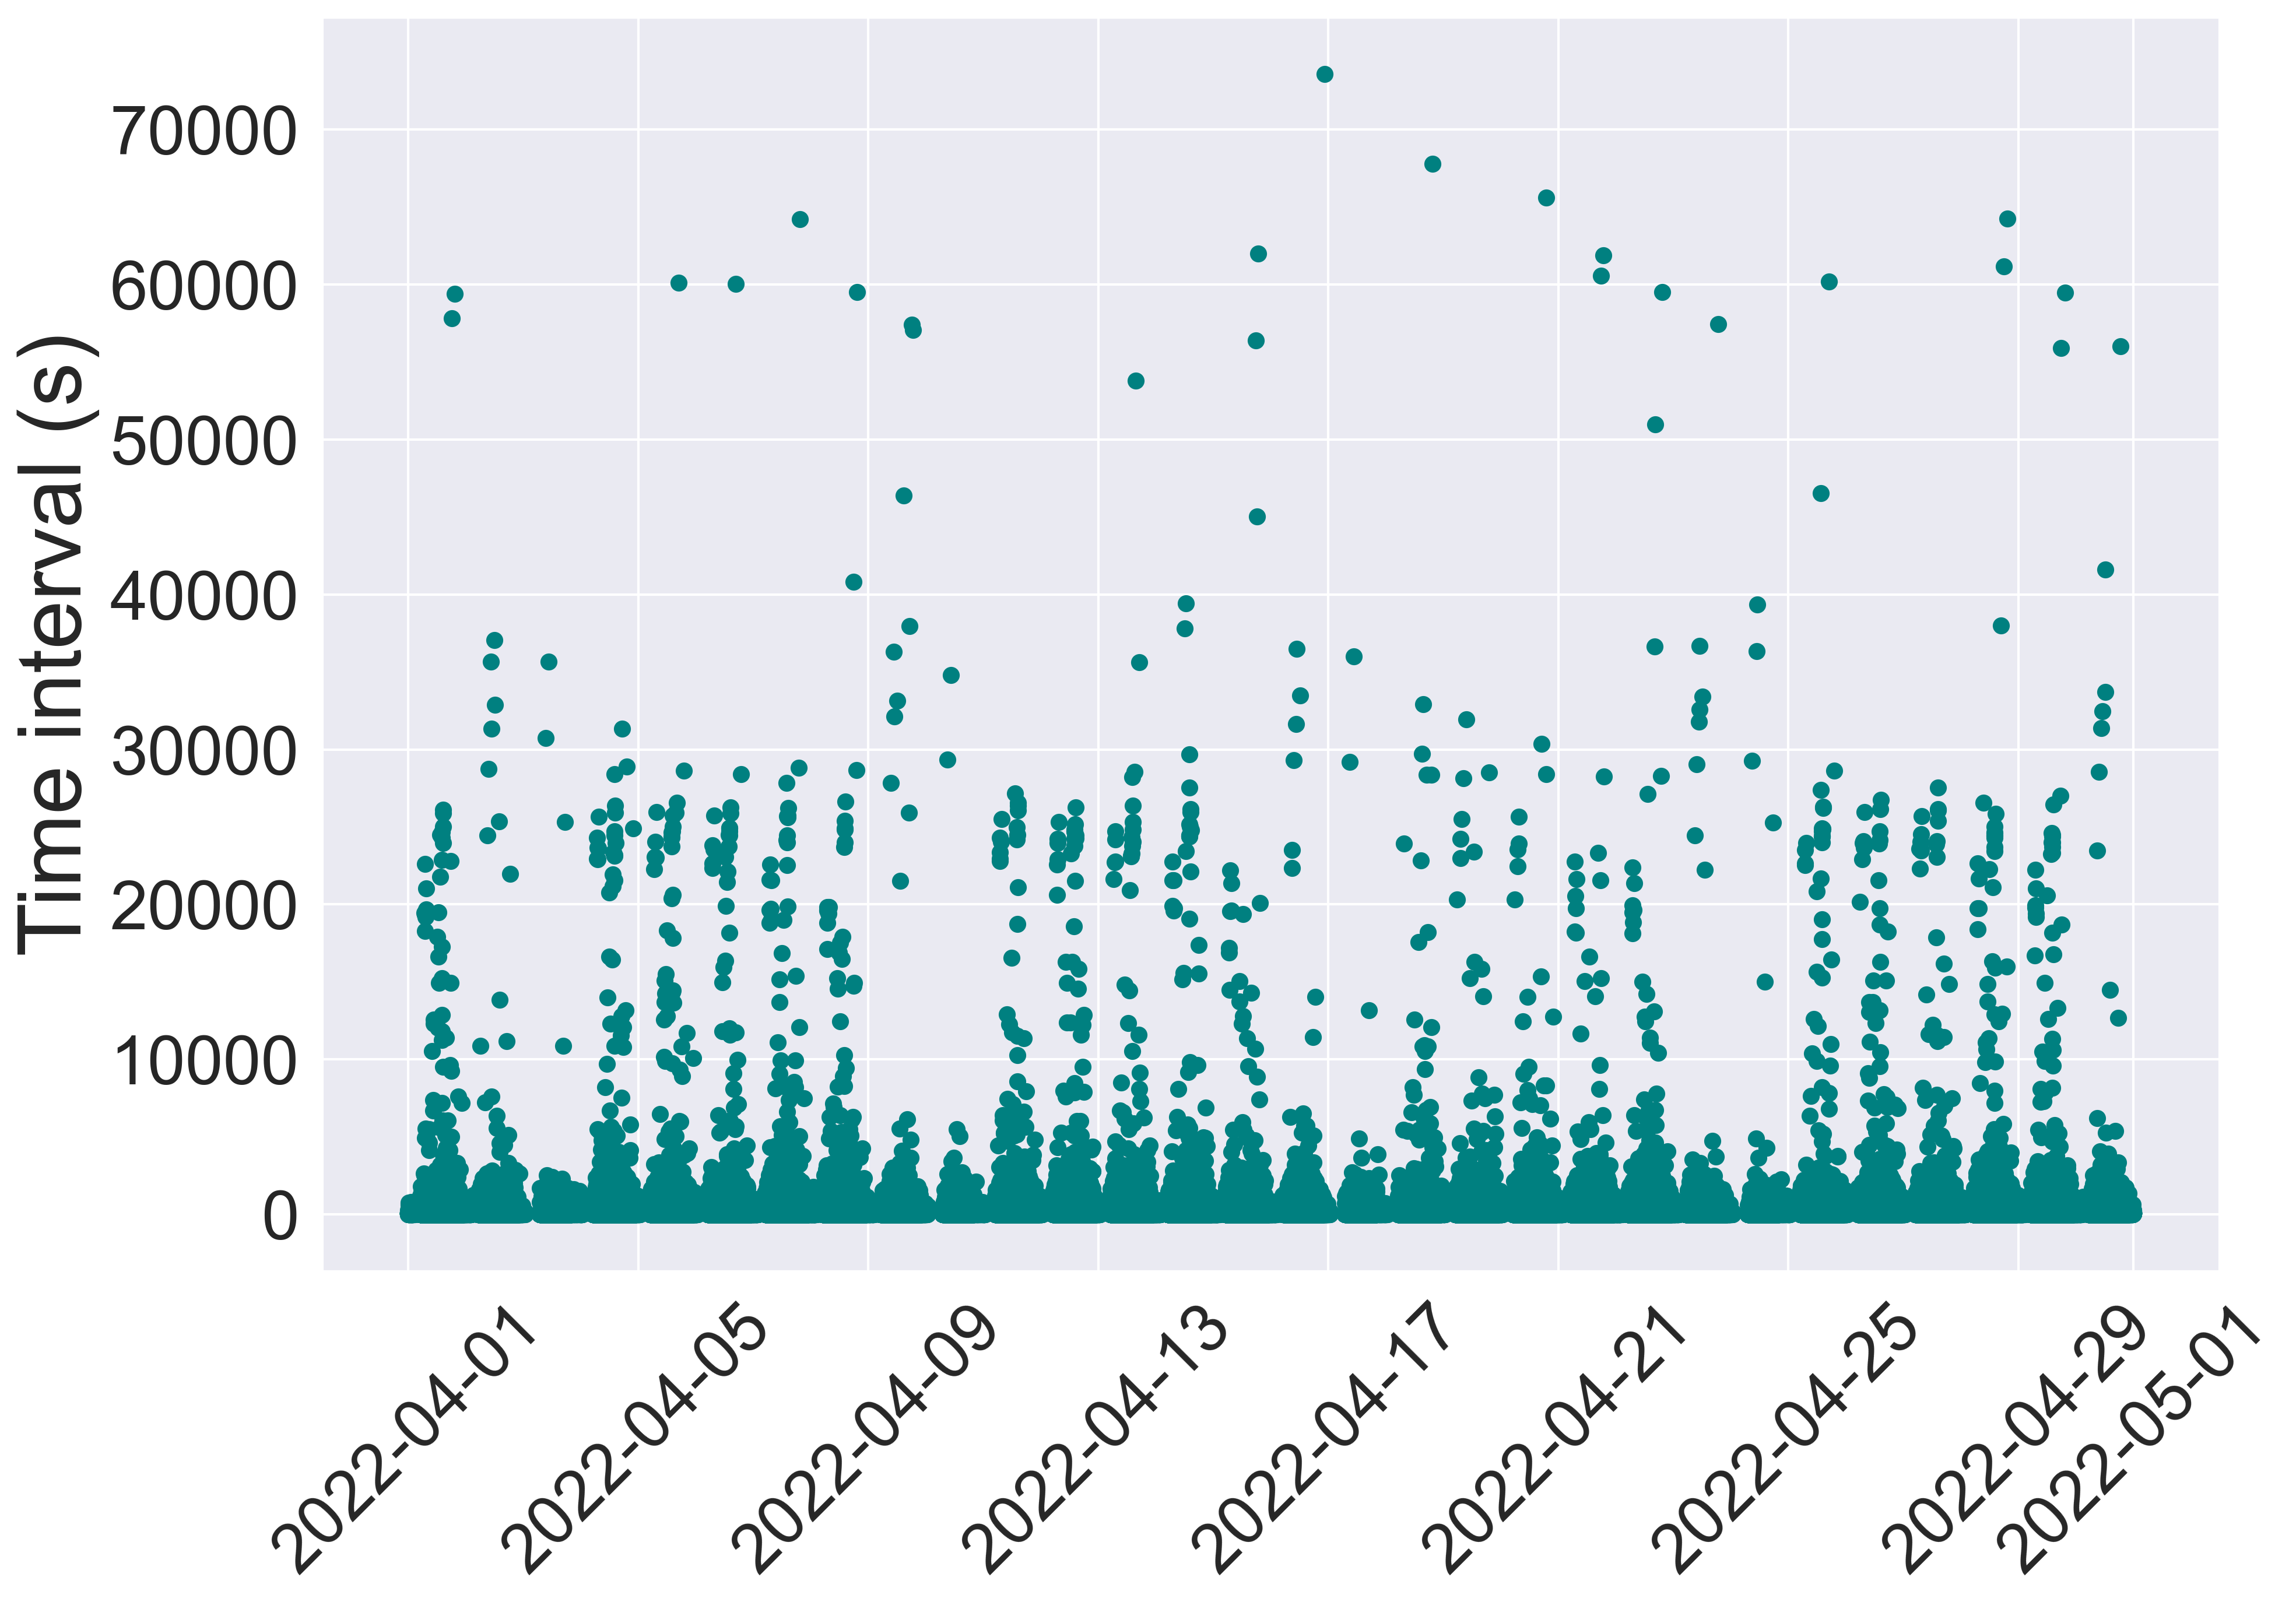

In [258]:
figure(figsize=(14, 9.5), dpi=300)
plt.plot_date(x=trajectories['ServiceDateTime']  , y=trajectories["time_delta_in_seconds"], fmt='o', tz=None, xdate=True, ydate=False, color='teal')
plt.ylabel("Time interval (s)", fontsize=36)
plt.xticks(fontsize=28, rotation = 45)
plt.yticks(fontsize=28)
#plt.savefig(r'../../figures/time-intervals.png', dpi=400, bbox_inches='tight')
plt.show()

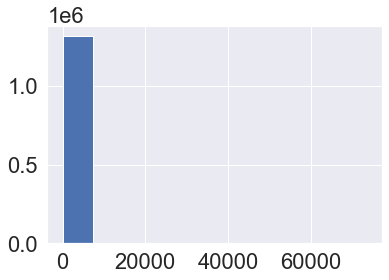

In [259]:
df_time_intervals = trajectories[trajectories['time_delta_in_seconds'] > 0]
plt.hist(df_time_intervals['time_delta_in_seconds'])
#plt.savefig(r'../../figures/hist-time-intervals.png', dpi=400, bbox_inches='tight')
plt.show()

In [356]:
len(df['Route'].unique())

49

In [357]:
#trajectories.to_csv(r'../../results/computed-trajectories-v02.csv')

In [358]:
df_acc = trajectories.sort_values('acc', ascending=False)
df_acc['acc']

1285352    20.1168
1353878    20.1168
1344102    20.1168
1342310    20.1168
1310230    20.1168
            ...   
1204528        NaN
1204529        NaN
1346261        NaN
1346262        NaN
1346263        NaN
Name: acc, Length: 1361253, dtype: float64

In [359]:
df_dist = trajectories.sort_values('dist', ascending=False)
df_dist['dist']

58278      18.700636
34202      15.433128
73737      15.433128
83983      15.433128
108408     15.433128
             ...    
1164119          NaN
1204527          NaN
1204528          NaN
1346261          NaN
1346262          NaN
Name: dist, Length: 1361253, dtype: float64

In [360]:
df_speed = trajectories.sort_values('speed', ascending=False)
df_speed['speed'].head(50000)

217603     90.000000
1062061    90.000000
1071328    90.000000
1335575    90.000000
1319291    90.000000
             ...    
618838     44.449289
386628     44.449289
82227      44.449289
310644     44.449289
68014      44.449289
Name: speed, Length: 50000, dtype: float64

In [361]:
trajectories['dist'].max()

18.700636389473715

In [362]:
trajectories['dist'].median()

0.1395764902777601

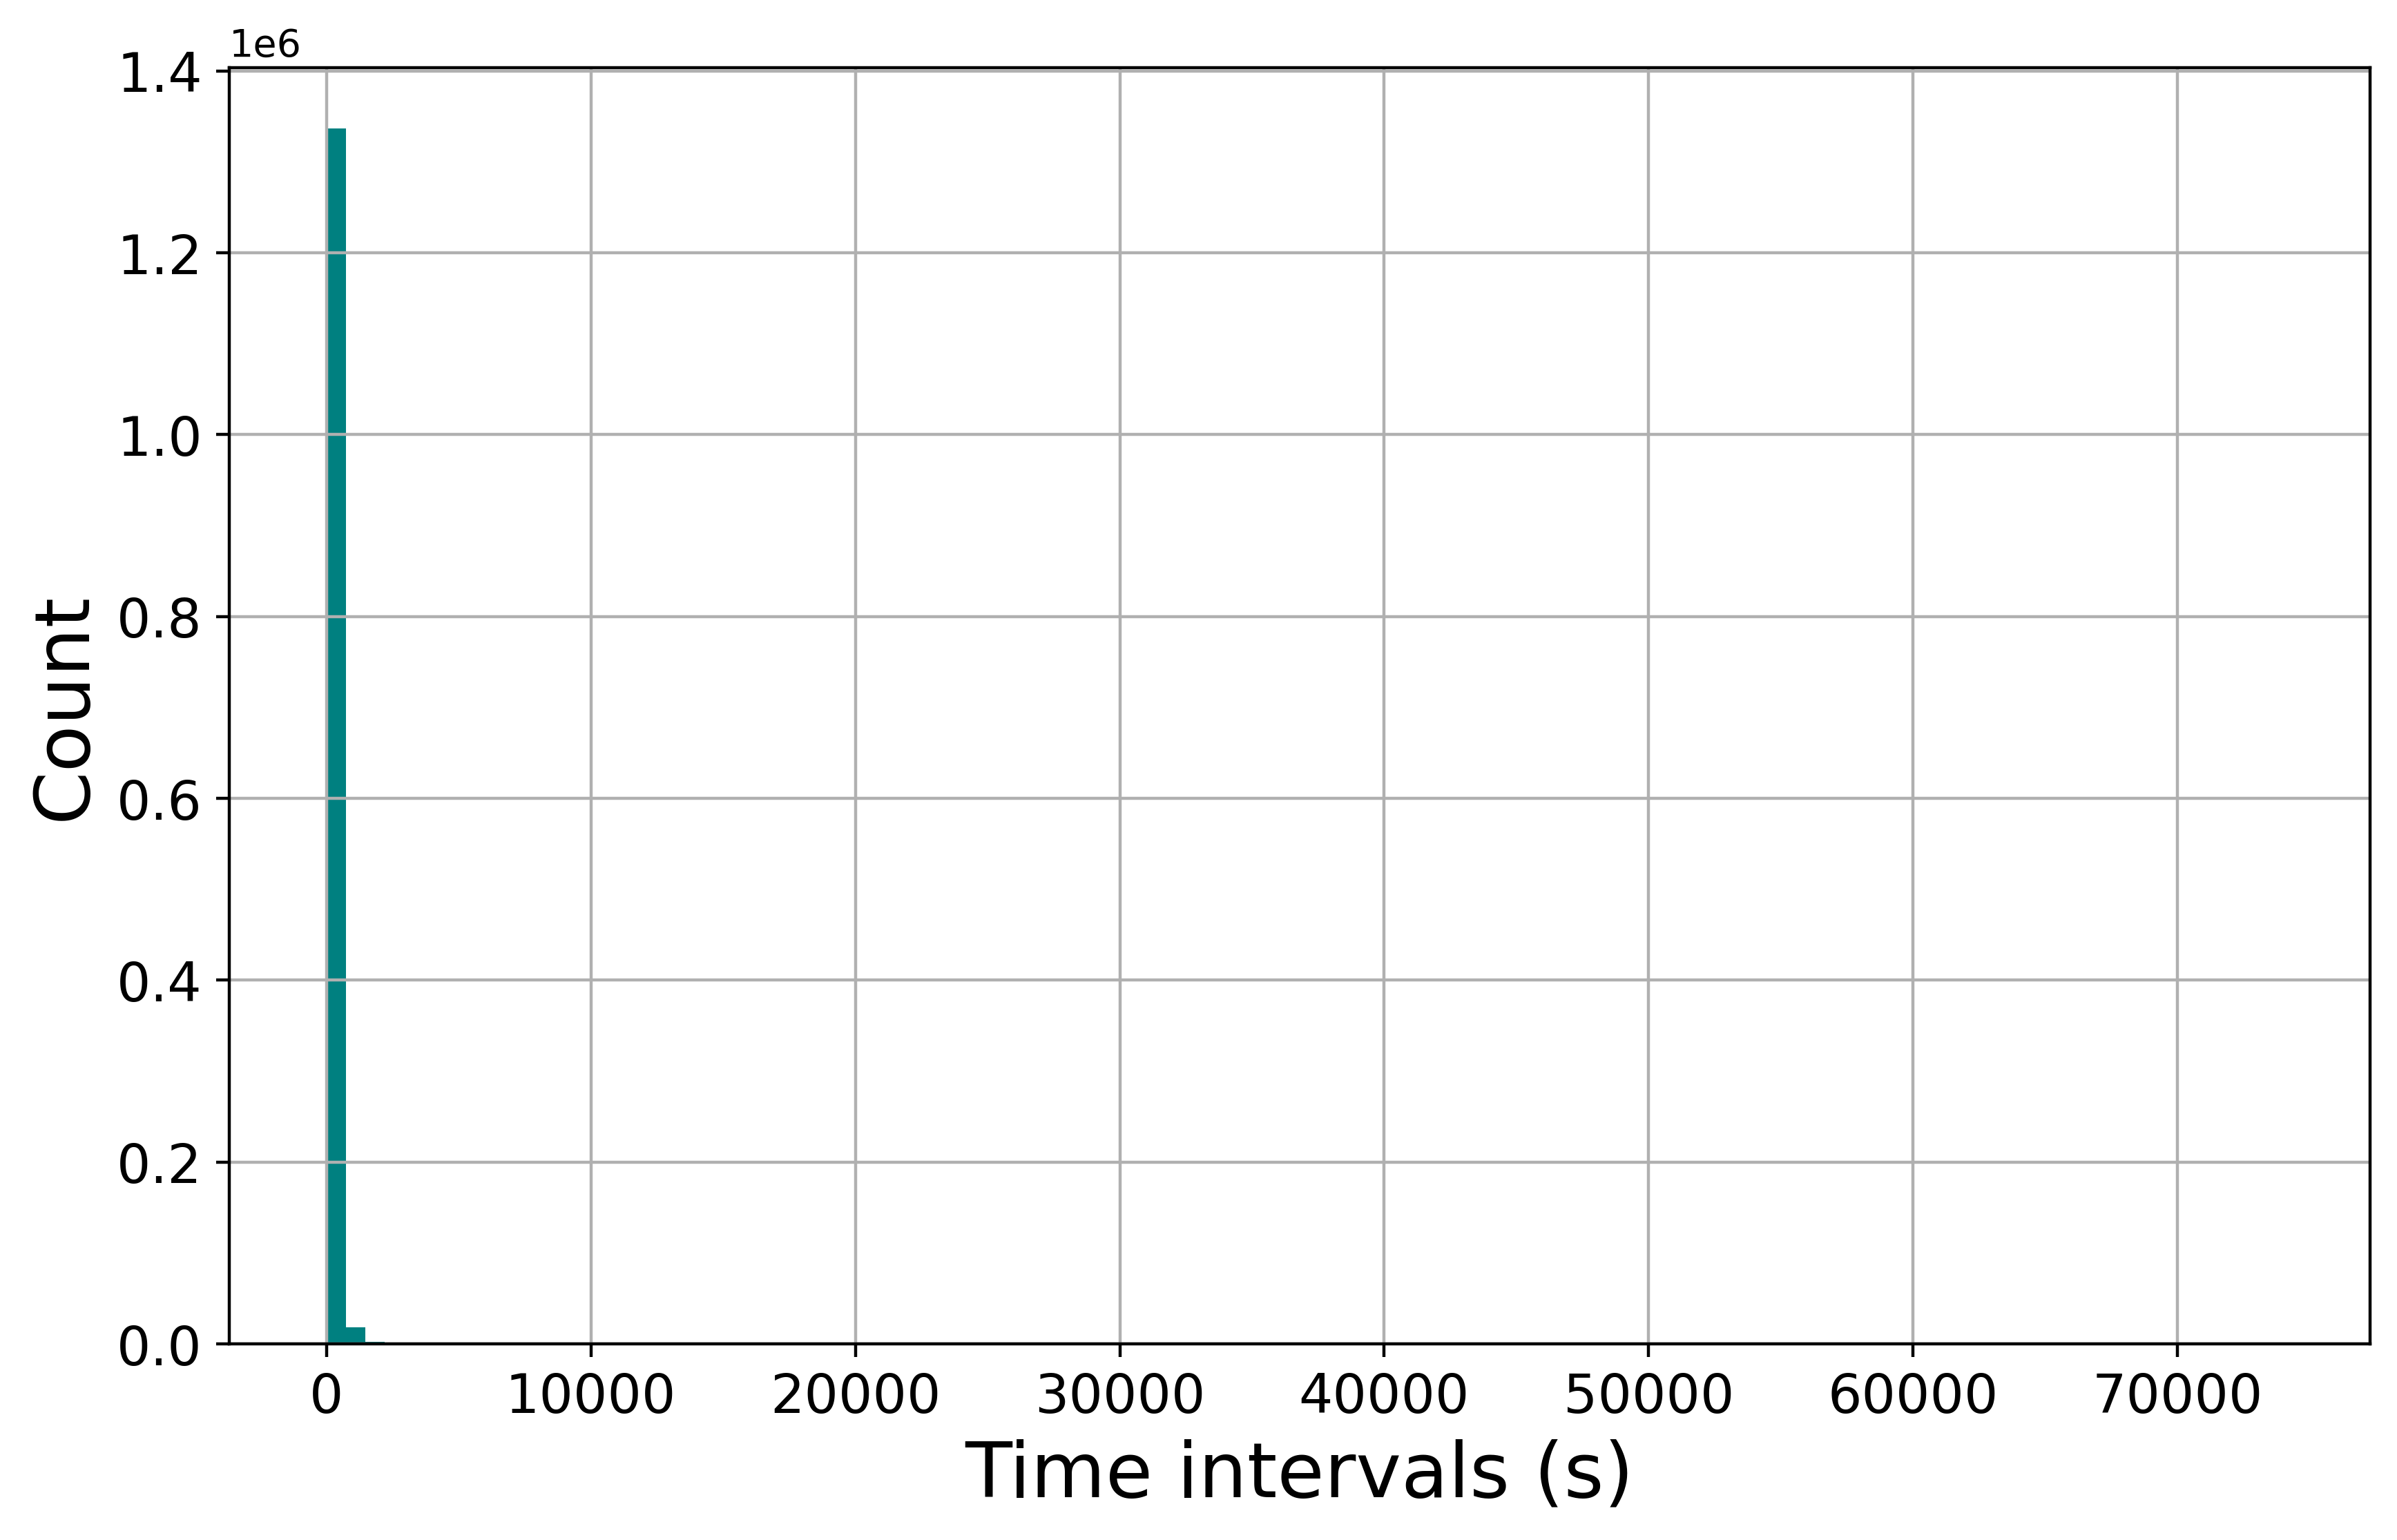

In [157]:
figure(figsize=(10, 6), dpi=400)
ax=trajectories['time_delta_in_seconds'].hist(bins=100, color='teal')
ax.set_xlabel('Time intervals (s)', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(r'../../figures/hist-time-intervals.png', dpi=400, bbox_inches='tight')

In [363]:
trajectories['time_delta_in_seconds'].max()

73596.0

In [364]:
trajectories['time_delta_in_seconds'].median()

41.0

In [365]:
trajectories['time_delta_in_seconds'].mean()

93.3055875431833

In [366]:
df_dist_outliers=trajectories[trajectories['dist']>15]

In [367]:
df_dist_outliers

ServiceDateTime  Unnamed: 0.1  Unnamed: 0  DateKey  \
108408 2022-04-01 17:51:03        108414       43654     8760   
73737  2022-04-04 17:50:27         73742      152939     8763   
34202  2022-04-05 17:53:05         34204      206300     8764   
83983  2022-04-08 06:35:13         83989      366354     8767   
84383  2022-04-08 17:52:24         84389      366875     8767   
129890 2022-04-11 08:52:46        129899      469666     8770   
111680 2022-04-11 17:55:02        111686      437762     8770   
325328 2022-04-12 06:30:46        325383      529847     8771   
388723 2022-04-12 06:38:18        388784      491128     8771   
381236 2022-04-13 06:37:44        381295      544246     8772   
445533 2022-04-18 05:30:25        445600      787246     8777   
132604 2022-04-18 15:25:51        132613      757842     8777   
58278  2022-04-18 17:13:14         58281      757850     8777   
70605  2022-04-25 17:50:45         70610     1060393     8784   
415569 2022-04-27 06:37:33        415631     1168049     8786   
144410 2022-04-29 17:55:46        144419     1273091     8788   

                   CalendarDate  Year  Month  OpKey Operator  RtKey  ...  \
108408  2022-04-01 00:00:00.000  2022      4      2    SATCo   3630  ...   
73737   2022-04-04 00:00:00.000  2022      4      2    SATCo   3630  ...   
34202   2022-04-05 00:00:00.000  2022      4      2    SATCo   3630  ...   
83983   2022-04-08 00:00:00.000  2022      4      2    SATCo   3620  ...   
84383   2022-04-08 00:00:00.000  2022      4      2    SATCo   3630  ...   
129890  2022-04-11 00:00:00.000  2022      4      2    SATCo   3655  ...   
111680  2022-04-11 00:00:00.000  2022      4      2    SATCo   3631  ...   
325328  2022-04-12 00:00:00.000  2022      4      2    SATCo   3664  ...   
388723  2022-04-12 00:00:00.000  2022      4      2    SATCo   3631  ...   
381236  2022-04-13 00:00:00.000  2022      4      2    SATCo   3631  ...   
445533  2022-04-18 00:00:00.000  2022      4      2    SATCo   3655  ...   
132604  2022-04-18 00:00:00.000  2022      4      2    SATCo   3631  ...   
58278   2022-04-18 00:00:00.000  2022      4      2    SATCo   3631  ...   
70605   2022-04-25 00:00:00.000  2022      4      2    SATCo   3631  ...   
415569  2022-04-27 00:00:00.000  2022      4      2    SATCo   3645  ...   
144410  2022-04-29 00:00:00.000  2022      4      2    SATCo   3631  ...   

        Minute Second        Date  Daytype      time      time_delta  \
108408      51      3  2022-04-01  Weekday  17:51:03 0 days 00:27:41   
73737       50     27  2022-04-04  Weekday  17:50:27 0 days 00:27:32   
34202       53      5  2022-04-05  Weekday  17:53:05 0 days 00:29:39   
83983       35     13  2022-04-08  Weekday  06:35:13 0 days 00:52:32   
84383       52     24  2022-04-08  Weekday  17:52:24 0 days 00:28:08   
129890      52     46  2022-04-11  Weekday  08:52:46 0 days 00:39:09   
111680      55      2  2022-04-11  Weekday  17:55:02 0 days 00:30:25   
325328      30     46  2022-04-12  Weekday  06:30:46 0 days 00:52:52   
388723      38     18  2022-04-12  Weekday  06:38:18 0 days 00:42:46   
381236      37     44  2022-04-13  Weekday  06:37:44 0 days 00:39:28   
445533      30     25  2022-04-18  Weekday  05:30:25 0 days 00:42:07   
132604      25     51  2022-04-18  Weekday  15:25:51 0 days 00:48:23   
58278       13     14  2022-04-18  Weekday  17:13:14 0 days 00:35:16   
70605       50     45  2022-04-25  Weekday  17:50:45 0 days 00:27:42   
415569      37     33  2022-04-27  Weekday  06:37:33 0 days 00:46:36   
144410      55     46  2022-04-29  Weekday  17:55:46 0 days 00:30:13   

        time_delta_in_seconds       dist      speed       acc  
108408                 1661.0  15.433128  33.449285  0.009003  
73737                  1652.0  15.433128  33.631514  0.009101  
34202                  1779.0  15.433128  31.230614  0.007848  
83983                  3152.0  15.433128  17.626669  0.002500  
84383                  1688.0  15.433128  32.914255  0.008717  
129

In [368]:
df_time_intervals_outliers=trajectories[trajectories['time_delta_in_seconds']>50000]

In [369]:
df_time_intervals_outliers

ServiceDateTime  Unnamed: 0.1  Unnamed: 0  DateKey  \
1334079 2022-04-01 18:14:07       1334372        1944     8760   
1346777 2022-04-01 19:24:26       1347071          21     8760   
1307420 2022-04-05 16:49:19       1307711      163144     8764   
1307661 2022-04-06 16:50:01       1307952      216585     8765   
1348822 2022-04-07 19:25:06       1349116      269361     8766   
1349118 2022-04-08 19:24:57       1349412      323256     8767   
1185775 2022-04-09 18:11:21       1186001      411711     8768   
1349402 2022-04-09 18:37:44       1349696      380420     8768   
1124970 2022-04-13 15:42:18       1125185      587700     8772   
1357940 2022-04-15 17:50:30       1358234      646219     8774   
1179219 2022-04-15 18:41:54       1179445      694124     8774   
1239636 2022-04-16 22:22:13       1239908      734460     8775   
1148085 2022-04-18 19:28:03       1148306      795469     8777   
1171547 2022-04-20 18:51:56       1171769      898015     8779   
1358564 2022-04-21 17:47:00       1358859      900195     8780   
1049405 2022-04-21 18:53:04       1049579      948594     8780   
1358860 2022-04-22 16:20:48       1359155      952535     8781   
1353526 2022-04-22 19:24:55       1353820      950795     8781   
1359215 2022-04-23 18:40:39       1359510     1004566     8782   
1332519 2022-04-25 16:51:07       1332812     1056403     8784   
1355464 2022-04-28 17:53:40       1355758     1214980     8787   
1360260 2022-04-28 19:23:58       1360556     1214984     8787   
1355756 2022-04-29 17:43:24       1356050     1268769     8788   
1360557 2022-04-29 19:24:38       1360853     1268774     8788   
1356073 2022-04-30 18:38:10       1356367     1326715     8789   

                    CalendarDate  Year  Month  OpKey Operator  RtKey  ...  \
1334079  2022-04-01 00:00:00.000  2022      4      1    VATCo   3515  ...   
1346777  2022-04-01 00:00:00.000  2022      4      1    VATCo   3410  ...   
1307420  2022-04-05 00:00:00.000  2022      4      1    VATCo   3410  ...   
1307661  2022-04-06 00:00:00.000  2022      4      1    VATCo   3410  ...   
1348822  2022-04-07 00:00:00.000  2022      4      1    VATCo   3410  ...   
1349118  2022-04-08 00:00:00.000  2022      4      1    VATCo   3410  ...   
1185775  2022-04-09 00:00:00.000  2022      4      3    UMASS   3622  ...   
1349402  2022-04-09 00:00:00.000  2022      4      1    VATCo   3519  ...   
1124970  2022-04-13 00:00:00.000  2022      4      3    UMASS   3624  ...   
1357940  2022-04-15 00:00:00.000  2022      4      1    VATCo   3410  ...   
1179219  2022-04-15 00:00:00.000  2022      4      3    UMASS   3625  ...   
1239636  2022-04-16 00:00:00.000  2022      4      3    UMASS   3625  ...   
1148085  2022-04-18 00:00:00.000  2022      4      3    UMASS   3624  ...   
1171547  2022-04-20 00:00:00.000  2022      4      3    UMASS   3626  ...   
1358564  2022-04-21 00:00:00.000  2022      4      1    VATCo   3410  ...   
1049405  2022-04-21 00:00:00.000  2022      4      3    UMASS   3626  ...   
1358860  2022-04-22 00:00:00.000  2022      4      1    VATCo   3515  ...   
1353526  2022-04-22 00:00:00.000  2022      4      1    VATCo   3410  ...   
1359215  2022-04-23 00:00:00.000  2022      4      1    VATCo   3519  ...   
1332519  2022-04-25 00:00:00.000  2022      4      1    VATCo   3410  ...   
1355464  2022-04-28 00:00:00.000  2022      4      1    VATCo   3410  ...   
1360260  2022-04-28 00:00:00.000  2022      4      1    VATCo   3410  ...   
1355756  2022-04-29 00:00:00.000  2022      4      1    VATCo   3410  ...   
1360557  2022-04-29 00:00:00.000  2022      4      1    VATCo   3410  ...   
1356073  2022-04-30 00:00:00.000  2022      4      1    VATCo   3519  ...   

         Minute Second        Date  Daytype      time      time_delta  \
1334079      14      7  2022-04-01  Weekday  18:14:07 0 days 16:03:31   
1346777      24     26  2022-04-01  Weekday  19:24:26 0 days 16:30:07   
1307420      49     19  2022-04-05  Weekday  16:49:19 0 days 16:41:46   


In [370]:
#df[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(df['Vehicle'] == 1642) & (df['Date'] == '2022-04-04') ]

In [372]:
trajectories[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(trajectories['Vehicle'] == 1642) & (trajectories['Date'] == '2022-04-04') ]

ServiceDateTime        Date  Vehicle      dist      speed       acc
151609 2022-04-04 07:14:26  2022-04-04     1642  0.000000   0.000000  0.000000
151610 2022-04-04 07:15:25  2022-04-04     1642  0.268592  16.388644  0.124176
151611 2022-04-04 07:16:27  2022-04-04     1642  0.310223  18.012945  0.011712
151612 2022-04-04 07:17:20  2022-04-04     1642  0.147543  10.021773 -0.067403
151613 2022-04-04 07:18:14  2022-04-04     1642  0.181551  12.103388  0.017233
151614 2022-04-04 07:19:42  2022-04-04     1642  0.474900  19.427711  0.037208
151615 2022-04-04 07:19:56  2022-04-04     1642  0.100140  25.750371  0.201892
151616 2022-04-04 07:20:43  2022-04-04     1642  0.110635   8.474147 -0.164323
151617 2022-04-04 07:21:22  2022-04-04     1642  0.154770  14.286429  0.066624
151618 2022-04-04 07:21:43  2022-04-04     1642  0.121848  20.888281  0.140538
151619 2022-04-04 07:23:03  2022-04-04     1642  0.021112   0.950030 -0.111415
151620 2022-04-04 07:23:03  2022-04-04     1642  0.000000   0.000000  0.000000
151621 2022-04-04 07:40:30  2022-04-04     1642  6.828609  23.479458  0.010025
151622 2022-04-04 14:06:01  2022-04-04     1642  0.000000   0.000000 -0.000454
151623 2022-04-04 14:28:51  2022-04-04     1642  1.638041   4.304342  0.001405
151624 2022-04-04 14:28:51  2022-04-04     1642  0.000000   0.000000  0.000000
151625 2022-04-04 14:29:22  2022-04-04     1642  0.076097   8.837121  0.127437
151626 2022-04-04 14:29:42  2022-04-04     1642  0.238878  42.998065  0.763565
151627 2022-04-04 14:30:04  2022-04-04     1642  0.196790  32.202001 -0.219376
151628 2022-04-04 14:31:48  2022-04-04     1642  0.150945   5.225026 -0.115959
151629 2022-04-04 14:32:23  2022-04-04     1642  0.221524  22.785323  0.224290
151630 2022-04-04 14:32:57  2022-04-04     1642  0.117994  12.493527 -0.135319
151631 2022-04-04 14:33:57  2022-04-04     1642  0.159463   9.567790 -0.021799
151632 2022-04-04 14:35:13  2022-04-04     1642  0.101656   4.815272 -0.027955
151633 2022-04-04 14:35:36  2022-04-04     1642  0.140320  21.963140  0.333295
151634 2022-04-04 14:37:59  2022-04-04     1642  0.347637   8.751709 -0.041301
151635 2022-04-04 14:38:29  2022-04-04     1642  0.114302  13.716233  0.073978
151636 2022-04-04 14:39:22  2022-04-04     1642  0.166958  11.340572 -0.020038
151637 2022-04-04 14:40:25  2022-04-04     1642  0.065020   3.715404 -0.054107
151638 2022-04-04 14:42:38  2022-04-04     1642  0.229239   6.204975  0.008368
151639 2022-04-04 14:43:07  2022-04-04     1642  0.212041  26.322322  0.310112
151640 2022-04-04 14:44:46  2022-04-04     1642  0.311025  11.309998 -0.067789
151641 2022-04-04 14:48:48  2022-04-04     1642  0.157536   2.343517 -0.016564
151642 2022-04-04 14:48:54  2022-04-04     1642  0.057970  34.782231  2.416901
151643 2022-04-04 14:50:25  2022-04-04     1642  0.323601  12.801780 -0.107980
151644 2022-04-04 14:50:25  2022-04-04     1642  0.000000   0.000000  0.000000

In [386]:
trajectories[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(trajectories['Vehicle'] == 1729) & (trajectories['Date'] == '2022-04-19') ]

ServiceDateTime        Date  Vehicle  dist  speed  acc
486099 2022-04-19 05:49:19  2022-04-19     1729   0.0    0.0  0.0

In [374]:
nans=trajectories[trajectories['dist'].isna()]

In [375]:
nans[['ServiceDateTime','Date','Vehicle','Lon','Lat','dist','speed','acc']]
#nans[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(nans['Vehicle'] == 1642) & (trajectories['Date'] == '2022-04-04') ]

ServiceDateTime        Date  Vehicle        Lon        Lat  dist  \
1093701 2022-04-01 07:01:50  2022-04-01     3307 -72.533010  42.393760   NaN   
1021510 2022-04-01 07:20:09  2022-04-01     3222 -72.533010  42.393760   NaN   
1078703 2022-04-01 07:24:38  2022-04-01     3305        NaN        NaN   NaN   
1078704 2022-04-01 07:31:01  2022-04-01     3305 -72.532480  42.405880   NaN   
1268208 2022-04-01 13:00:52  2022-04-01     7552 -72.633052  42.317699   NaN   
...                     ...         ...      ...        ...        ...   ...   
1164119 2022-04-29 07:15:45  2022-04-29     3313 -72.533010  42.393760   NaN   
1204527 2022-04-29 08:24:42  2022-04-29     3319        NaN        NaN   NaN   
1204528 2022-04-29 08:28:34  2022-04-29     3319 -72.533010  42.393760   NaN   
1346261 2022-04-29 14:00:00  2022-04-29     7816        NaN        NaN   NaN   
1346262 2022-04-29 14:05:54  2022-04-29     7816 -72.633050  42.317700   NaN   

         speed  acc  
1093701    NaN  NaN  
1021510    NaN  NaN  
1078703    NaN  NaN  
1078704    NaN  NaN  
1268208    NaN  NaN  
...        ...  ...  
1164119    NaN  NaN  
1204527    NaN  NaN  
1204528    NaN  NaN  
1346261    NaN  NaN  
1346262    NaN  NaN  

[89 rows x 8 columns]

In [376]:
df[df['dist'].isna()]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
1015375 2022-04-12 09:08:42      530273     8771  2022-04-12 00:00:00.000   
1016670 2022-04-23 10:45:48     1038647     8782  2022-04-23 00:00:00.000   
1017014 2022-04-24 10:43:48     1056369     8783  2022-04-24 00:00:00.000   
1017911 2022-04-26 09:08:18     1160410     8785  2022-04-26 00:00:00.000   
1020514 2022-04-15 07:27:11      687917     8774  2022-04-15 00:00:00.000   
...                     ...         ...      ...                      ...   
1342414 2022-04-11 14:00:34      434847     8770  2022-04-11 00:00:00.000   
1345596 2022-04-23 16:00:45     1003542     8782  2022-04-23 00:00:00.000   
1345659 2022-04-24 09:07:09     1038714     8783  2022-04-24 00:00:00.000   
1346555 2022-04-29 14:00:00     1271377     8788  2022-04-29 00:00:00.000   
1346556 2022-04-29 14:05:54     1271378     8788  2022-04-29 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
1015375  2022      4      3    UMASS   3391    1732  ...      8     42   
1016670  2022      4      3    UMASS   3709    1732  ...     45     48   
1017014  2022      4      3    UMASS   3709    1732  ...     43     48   
1017911  2022      4      3    UMASS   3709    1732  ...      8     18   
1020514  2022      4      3    UMASS   3391    1732  ...     27     11   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1342414  2022      4      1    VATCo   3515    1001  ...      0     34   
1345596  2022      4      1    VATCo   3516    1002  ...      0     45   
1345659  2022      4      1    VATCo   3515    1001  ...      7      9   
1346555  2022      4      1    VATCo   3516    1002  ...      0      0   
1346556  2022      4      1    VATCo   3516    1002  ...      5     54   

               Date  Daytype      time          time_delta  \
1015375  2022-04-12  Weekday  09:08:42 2022-12-04 00:00:41   
1016670  2022-04-23  Weekend  10:45:48 2022-12-04 00:09:21   
1017014  2022-04-24  Weekend  10:43:48 2022-12-04 00:10:13   
1017911  2022-04-26  Weekday  09:08:18 2022-12-04 02:31:43   
1020514  2022-04-15  Weekday  07:27:11 2022-12-04 00:04:44   
...             ...      ...       ...                 ...   
1342414  2022-04-11  Weekday  14:00:34 2022-12-04 00:02:34   
1345596  2022-04-23  Weekend  16:00:45 2022-12-04 00:00:45   
1345659  2022-04-24  Weekend  09:07:09 2022-12-04 00:03:09   
1346555  2022-04-29  Weekday  14:00:00 2022-12-04 00:04:00   
1346556  2022-04-29  Weekday  14:05:54 2022-12-04 00:05:54   

        time_delta_in_seconds  dist  speed  acc  
1015375                  41.0   NaN    NaN  NaN  
1016670                 561.0   NaN    NaN  NaN  
1017014                 613.0   NaN    NaN  NaN  
1017911                9103.0   NaN    NaN  NaN  
1020514                 284.0   NaN    NaN  NaN  
...                       ...   ...    ...  ...  
1342414                 154.0   NaN    NaN  NaN  
1345596                  45.0   NaN    NaN  NaN  
1345659                 189.0   NaN    NaN  NaN  
1346555                 240.0   NaN    NaN  NaN  
1346556                 354.0   NaN    NaN  NaN  

[89 rows x 40 columns]

In [377]:
df['Vehicle'][df['dist'].isna()].unique()

array([3212, 3221, 3222, 3225, 3228, 3301, 3302, 3303, 3305, 3306, 3307,
       3311, 3312, 3313, 3314, 3316, 3317, 3318, 3319, 3322, 3324, 3402,
       3501, 7552, 7610, 7660, 7661, 7662, 7802, 7811, 7813, 7814, 7815,
       7816], dtype=int64)

In [163]:
df[df['Lat'].isna()]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
1015374 2022-04-12 09:08:01      530272     8771  2022-04-12 00:00:00.000   
1016669 2022-04-23 10:36:27     1038646     8782  2022-04-23 00:00:00.000   
1017013 2022-04-24 10:33:35     1056368     8783  2022-04-24 00:00:00.000   
1017910 2022-04-26 06:36:35     1160371     8785  2022-04-26 00:00:00.000   
1020513 2022-04-15 07:22:27      687916     8774  2022-04-15 00:00:00.000   
...                     ...         ...      ...                      ...   
1342413 2022-04-11 13:58:00      434846     8770  2022-04-11 00:00:00.000   
1345595 2022-04-23 16:00:00     1003541     8782  2022-04-23 00:00:00.000   
1345658 2022-04-24 09:04:00     1038713     8783  2022-04-24 00:00:00.000   
1346554 2022-04-29 13:56:00     1271375     8788  2022-04-29 00:00:00.000   
1346555 2022-04-29 14:00:00     1271377     8788  2022-04-29 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
1015374  2022      4      3    UMASS   3391    1732  ...      8      1   
1016669  2022      4      3    UMASS   3709    1732  ...     36     27   
1017013  2022      4      3    UMASS   3709    1732  ...     33     35   
1017910  2022      4      3    UMASS   3709    1732  ...     36     35   
1020513  2022      4      3    UMASS   3391    1732  ...     22     27   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1342413  2022      4      1    VATCo   3515    1001  ...     58      0   
1345595  2022      4      1    VATCo   3516    1002  ...      0      0   
1345658  2022      4      1    VATCo   3515    1001  ...      4      0   
1346554  2022      4      1    VATCo   3516    1002  ...     56      0   
1346555  2022      4      1    VATCo   3516    1002  ...      0      0   

               Date  Daytype      time          time_delta  \
1015374  2022-04-12  Weekday  09:08:01                 NaT   
1016669  2022-04-23  Weekend  10:36:27                 NaT   
1017013  2022-04-24  Weekend  10:33:35                 NaT   
1017910  2022-04-26  Weekday  06:36:35                 NaT   
1020513  2022-04-15  Weekday  07:22:27                 NaT   
...             ...      ...       ...                 ...   
1342413  2022-04-11  Weekday  13:58:00                 NaT   
1345595  2022-04-23  Weekend  16:00:00                 NaT   
1345658  2022-04-24  Weekend  09:04:00                 NaT   
1346554  2022-04-29  Weekday  13:56:00                 NaT   
1346555  2022-04-29  Weekday  14:00:00 2022-12-04 00:04:00   

        time_delta_in_seconds  dist  speed  acc  
1015374                   NaN   0.0    0.0  0.0  
1016669                   NaN   0.0    0.0  0.0  
1017013                   NaN   0.0    0.0  0.0  
1017910                   NaN   0.0    0.0  0.0  
1020513                   NaN   0.0    0.0  0.0  
...                       ...   ...    ...  ...  
1342413                   NaN   0.0    0.0  0.0  
1345595                   NaN   0.0    0.0  0.0  
1345658                   NaN   0.0    0.0  0.0  
1346554                   NaN   0.0    0.0  0.0  
1346555                 240.0   NaN    NaN  NaN  

[89 rows x 40 columns]

In [164]:
df[df['Lon'].isna()]

ServiceDateTime  Unnamed: 0  DateKey             CalendarDate  \
1015374 2022-04-12 09:08:01      530272     8771  2022-04-12 00:00:00.000   
1016669 2022-04-23 10:36:27     1038646     8782  2022-04-23 00:00:00.000   
1017013 2022-04-24 10:33:35     1056368     8783  2022-04-24 00:00:00.000   
1017910 2022-04-26 06:36:35     1160371     8785  2022-04-26 00:00:00.000   
1020513 2022-04-15 07:22:27      687916     8774  2022-04-15 00:00:00.000   
...                     ...         ...      ...                      ...   
1342413 2022-04-11 13:58:00      434846     8770  2022-04-11 00:00:00.000   
1345595 2022-04-23 16:00:00     1003541     8782  2022-04-23 00:00:00.000   
1345658 2022-04-24 09:04:00     1038713     8783  2022-04-24 00:00:00.000   
1346554 2022-04-29 13:56:00     1271375     8788  2022-04-29 00:00:00.000   
1346555 2022-04-29 14:00:00     1271377     8788  2022-04-29 00:00:00.000   

         Year  Month  OpKey Operator  RtKey  RtKey2  ... Minute Second  \
1015374  2022      4      3    UMASS   3391    1732  ...      8      1   
1016669  2022      4      3    UMASS   3709    1732  ...     36     27   
1017013  2022      4      3    UMASS   3709    1732  ...     33     35   
1017910  2022      4      3    UMASS   3709    1732  ...     36     35   
1020513  2022      4      3    UMASS   3391    1732  ...     22     27   
...       ...    ...    ...      ...    ...     ...  ...    ...    ...   
1342413  2022      4      1    VATCo   3515    1001  ...     58      0   
1345595  2022      4      1    VATCo   3516    1002  ...      0      0   
1345658  2022      4      1    VATCo   3515    1001  ...      4      0   
1346554  2022      4      1    VATCo   3516    1002  ...     56      0   
1346555  2022      4      1    VATCo   3516    1002  ...      0      0   

               Date  Daytype      time          time_delta  \
1015374  2022-04-12  Weekday  09:08:01                 NaT   
1016669  2022-04-23  Weekend  10:36:27                 NaT   
1017013  2022-04-24  Weekend  10:33:35                 NaT   
1017910  2022-04-26  Weekday  06:36:35                 NaT   
1020513  2022-04-15  Weekday  07:22:27                 NaT   
...             ...      ...       ...                 ...   
1342413  2022-04-11  Weekday  13:58:00                 NaT   
1345595  2022-04-23  Weekend  16:00:00                 NaT   
1345658  2022-04-24  Weekend  09:04:00                 NaT   
1346554  2022-04-29  Weekday  13:56:00                 NaT   
1346555  2022-04-29  Weekday  14:00:00 2022-12-04 00:04:00   

        time_delta_in_seconds  dist  speed  acc  
1015374                   NaN   0.0    0.0  0.0  
1016669                   NaN   0.0    0.0  0.0  
1017013                   NaN   0.0    0.0  0.0  
1017910                   NaN   0.0    0.0  0.0  
1020513                   NaN   0.0    0.0  0.0  
...                       ...   ...    ...  ...  
1342413                   NaN   0.0    0.0  0.0  
1345595                   NaN   0.0    0.0  0.0  
1345658                   NaN   0.0    0.0  0.0  
1346554                   NaN   0.0    0.0  0.0  
1346555                 240.0   NaN    NaN  NaN  

[89 rows x 40 columns]

In [378]:
less_tan_two_seconds=trajectories[trajectories['time_delta_in_seconds']<2]

In [379]:
less_tan_two_seconds[less_tan_two_seconds['dist']>0]

Empty DataFrame
Columns: [ServiceDateTime, Unnamed: 0.1, Unnamed: 0, DateKey, CalendarDate, Year, Month, OpKey, Operator, RtKey, RtKey2, Route, RouteName, TripKey, Trip, StopKey, Stop, StopName, Lat, Lon, Vehicle, VehicleType, SeatedCap, TotalCap, Boards, Alights, Onboard, Bike, Wheelchair, Weekday, Hour, Minute, Second, Date, Daytype, time, time_delta, time_delta_in_seconds, dist, speed, acc]
Index: []

[0 rows x 41 columns]

In [380]:
bad_points=df[df['time_delta_in_seconds']< 2]

In [382]:
trajectories[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(trajectories['Vehicle'] == 7902 & (trajectories['Date'] == '2022-04-08'))]

Empty DataFrame
Columns: [ServiceDateTime, Date, Vehicle, dist, speed, acc]
Index: []

In [383]:
trajectories[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(trajectories['Vehicle'] == 3303)]

ServiceDateTime        Date  Vehicle      dist      speed  \
1061897 2022-04-01 00:00:00  2022-04-01     3303  0.000000   0.000000   
1061898 2022-04-01 00:01:11  2022-04-01     3303  0.159006   8.062252   
1061899 2022-04-01 00:05:27  2022-04-01     3303  0.253337   3.562557   
1061900 2022-04-01 00:06:13  2022-04-01     3303  0.072114   5.643678   
1061901 2022-04-01 00:07:43  2022-04-01     3303  0.067056   2.682246   
...                     ...         ...      ...       ...        ...   
1074872 2022-04-29 20:49:24  2022-04-29     3303  0.307753  11.913031   
1074873 2022-04-29 20:50:11  2022-04-29     3303  0.204431  15.658522   
1074874 2022-04-29 20:50:49  2022-04-29     3303  0.094113   8.915984   
1074875 2022-04-29 20:50:49  2022-04-29     3303  0.000000   0.000000   
1074876 2022-04-29 20:52:07  2022-04-29     3303  0.106590   4.919551   

              acc  
1061897  0.000000  
1061898  0.050763  
1061899 -0.007858  
1061900  0.020225  
1061901 -0.014710  
...           ...  
1074872  0.034135  
1074873  0.035625  
1074874 -0.079321  
1074875  0.000000  
1074876  0.028195  

[12980 rows x 6 columns]

In [484]:
trajectories[['ServiceDateTime','Date','Vehicle','dist','speed','acc']][(trajectories['Vehicle'] == 7902) & (trajectories['Date'] == '2022-04-11') ]

ServiceDateTime        Date  Vehicle      dist      speed  \
1357079 2022-04-11 10:25:49  2022-04-11     7902  0.000000   0.000000   
1357080 2022-04-11 10:34:00  2022-04-11     7902  0.000000   0.000000   
1357081 2022-04-11 10:36:17  2022-04-11     7902  0.631544  16.595308   
1357082 2022-04-11 10:36:17  2022-04-11     7902  0.000000   0.000000   
1357083 2022-04-11 10:39:29  2022-04-11     7902  0.313431   5.876833   
...                     ...         ...      ...       ...        ...   
1357311 2022-04-11 18:11:36  2022-04-11     7902  0.203997  22.949681   
1357312 2022-04-11 18:13:37  2022-04-11     7902  0.249247   7.415607   
1357313 2022-04-11 18:17:36  2022-04-11     7902  0.219698   3.309266   
1357314 2022-04-11 18:19:04  2022-04-11     7902  0.208149   8.515180   
1357315 2022-04-11 18:20:47  2022-04-11     7902  0.295510  10.328507   

              acc  
1357079  0.000000  
1357080  0.000000  
1357081  0.054152  
1357082  0.000000  
1357083  0.013683  
...           ...  
1357311  0.042521  
1357312 -0.057391  
1357313 -0.007681  
1357314  0.026446  
1357315  0.007870  

[237 rows x 6 columns]

In [489]:
trajectories['dist'][(trajectories['Vehicle'] == 7902) & (trajectories['Date'] == '2022-04-13')].sum()

87.46669297702144